# Test 1 on kepler data 

Test 1 on Kepler data aims to examine the performance of a random forest also considering the follow-up characteristics

In [35]:
import pandas as pd
import sys
import os

# Added paths to import modules
sys.path.insert(0, os.path.abspath('../'))

# import custom modules
from data_processing.distribution import (plot_class_distribution, plot_feature_importances,
                                          plot_scatter_feature_distributions, 
                                          plot_hist_feature_distributions,
                                          plot_hist_feature_distributions_0_1,
                                          compute_train_0_1)
from data_processing.data_analysis import (compute_all_columns_nan, print_nan_numbers_for_features,
                                           threshold_delete_nan)
from data_processing.data_scaling import plot_top_7_difference, data_scaling_normalization
from data_processing.features_prosessing import remove_non_numeric_columns, rows_id_nan
from data_processing.knn_imputer import k_nearest_neighbors_imputer
from data_processing.replace_disposition import replace_label
from dimensionality_reduction.features_selection import compute_feature_importance, feature_selection_rfc
from model_selection.grid_search import grid_search_param_optimization
from utils.mission import Mission
from utils.util import print_count_nan, print_feature_importance, plot_confusion_matrix

# Read Data

read the csv file taken from:
1. Kepler: NASA Exoplanet Archive  http://exoplanetarchive.ipac.caltech.edu

In [8]:
kepler_data = pd.read_csv('../data/raw_data/cumulative_2023.11.04_08.48.13.csv')
print('Shape of Kepler Cumulative KOI', kepler_data.shape)
_ = print_count_nan(data=kepler_data, name='Kepler Cumulative KOI')

Shape of Kepler Cumulative KOI (9564, 141)
Number of not a numbers values in Kepler Cumulative KOI: 237116 out of 1348524: 17.58%


# Replace Label

In the data initially there is an disposition that includes 3 or more classes.

Kepler:
1. CONFIRMED
2. CANDIDATE
3. FALSE POSITIVE

with the aim of making a binary classifier we use the following procedure to replace:
1. CONFIRMED, CANDIDATE with the label: 1
2. FALSE POSITIVE with the label: 0

In [9]:
kepler_data = replace_label(data=kepler_data, mission=Mission.KEPLER)
print('Shape of kepler data: ', kepler_data.shape)

Shape of kepler data:  (9564, 141)


# Feature and Label Processing

The Kepler and TESS data have different features, so we want to find an intersection between the two sets of data. To do this, we perform several operations:

1. Removing non-numeric features
2. Removing of identifying and follow-up characteristics
3. Identifying the labels (X_train, y_train)
4. Removing NaN in y_train and correspondingly also the X_train rows (if there are)

In [10]:
kepler_data, non_numeric_columns = remove_non_numeric_columns(df=kepler_data)
print('Non numric columns removed:', non_numeric_columns)

Non numric columns removed: ['kepoi_name', 'kepler_name', 'koi_vet_stat', 'koi_vet_date', 'koi_pdisposition', 'koi_disp_prov', 'koi_comment', 'koi_fittype', 'koi_limbdark_mod', 'koi_parm_prov', 'koi_tce_delivname', 'koi_quarters', 'koi_trans_mod', 'koi_datalink_dvr', 'koi_datalink_dvs', 'koi_sparprov']


In [11]:
columns_to_remove = ['rowid','kepid']
kepler_data = kepler_data.drop(columns=columns_to_remove)

In [12]:
y_train = kepler_data['koi_disposition']
kepler_data = kepler_data.drop(columns='koi_disposition')
X_train = kepler_data

In [13]:
print('Shape of X_train data: ', X_train.shape)
print('Shape of y_train data: ', y_train.shape)
_ = print_count_nan(data=y_train, name='y_train')

Shape of X_train data:  (9564, 122)
Shape of y_train data:  (9564,)
Number of not a numbers values in y_train: 0 out of 9564: 0.00%


# Data Scaling

Plot Before the scaling


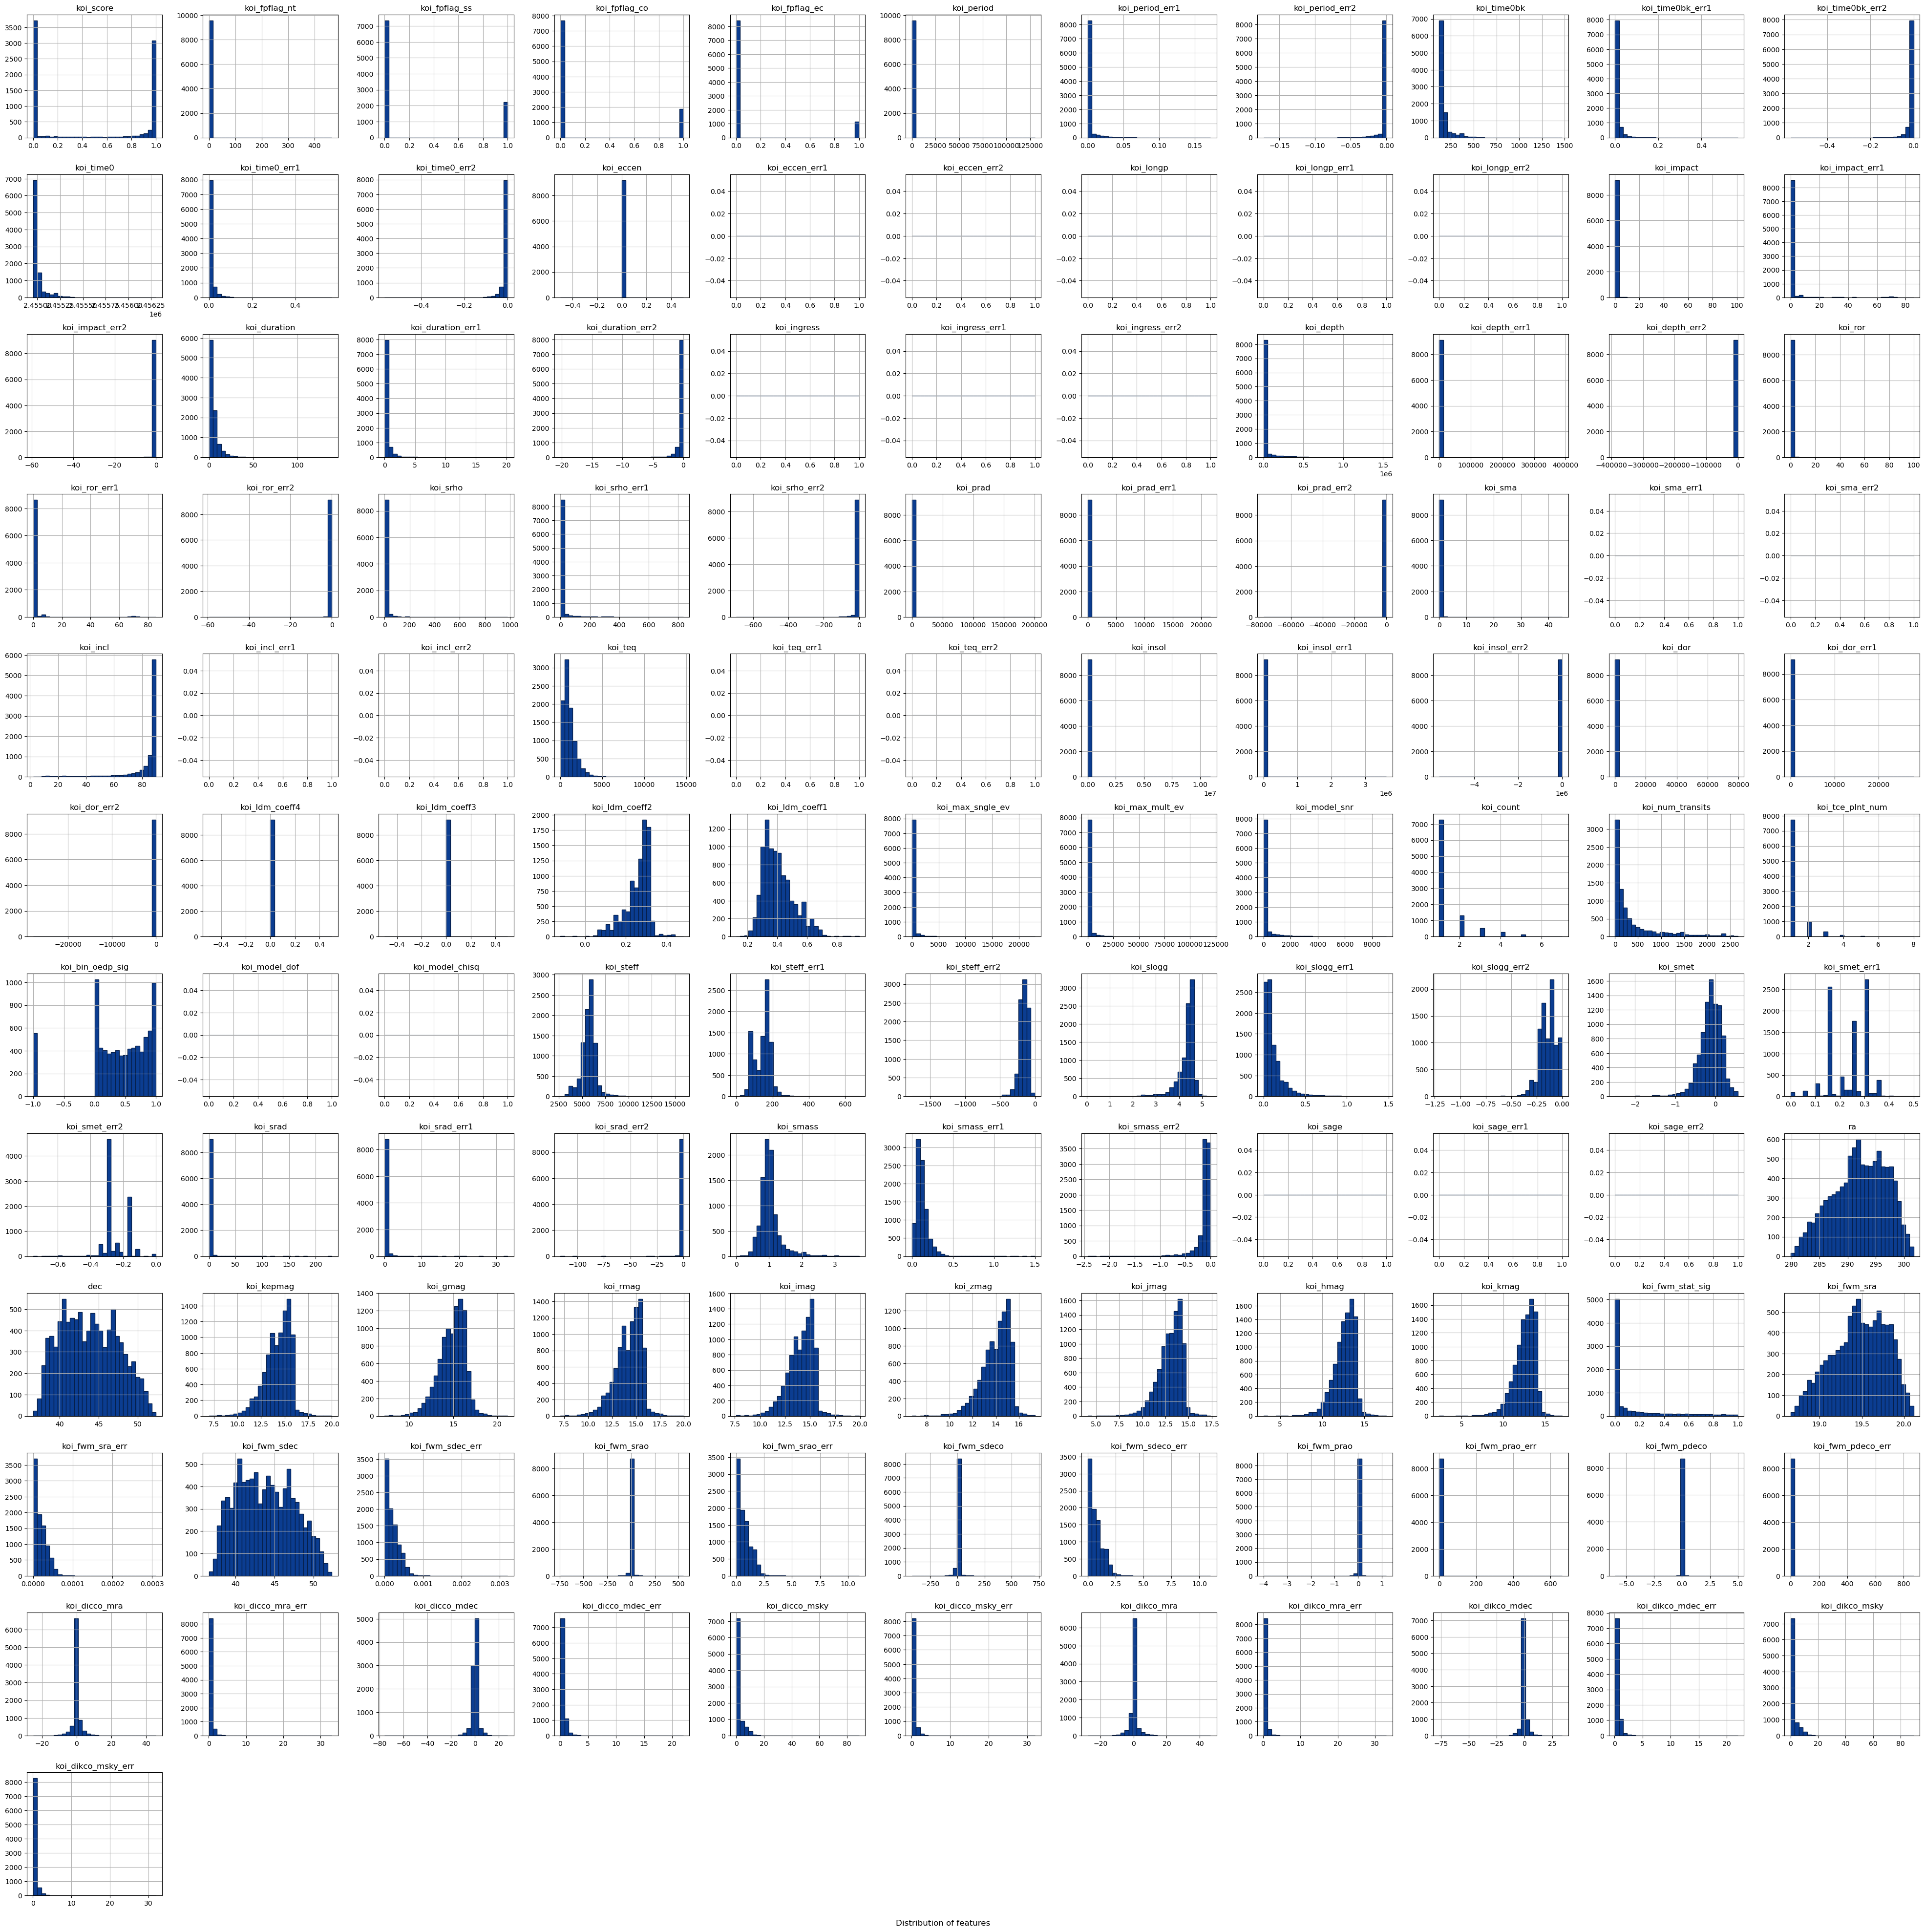

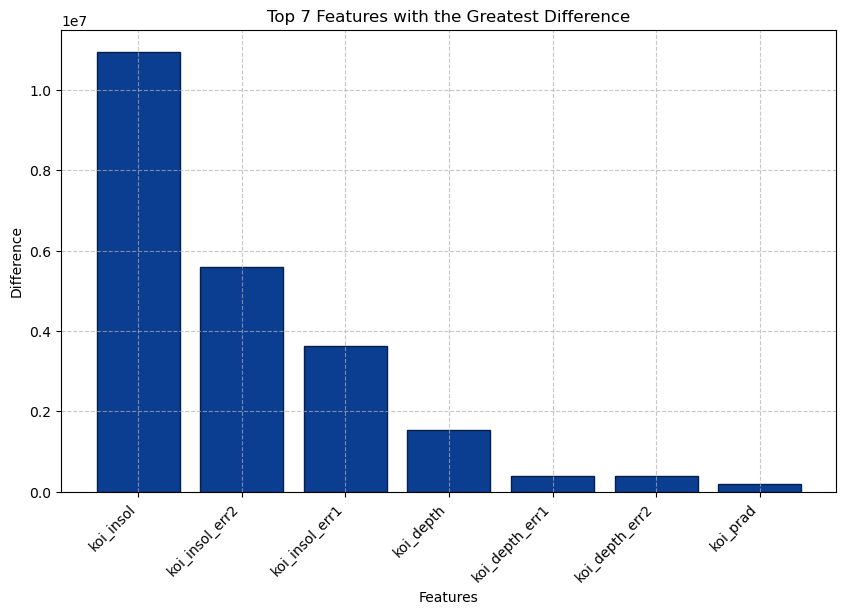

In [14]:
print('Plot Before the scaling')
plot_hist_feature_distributions(X_train=X_train)
plot_top_7_difference(X_train=X_train)

In [15]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_train_normalized = scaler.fit_transform(X_train)
X_train = pd.DataFrame(X_train_normalized, columns=X_train.columns)

/home/attilio/miniconda3/envs/exonet/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:480: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/home/attilio/miniconda3/envs/exonet/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:481: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)


# K-Nearest Neighbors

The NaN problem must be managed carefully, there are several solutions that can be used, one of these is the KNN methodology which calculates a distance (e.g. Euclidean or Manhattan) between the observations and calculates the new value to be inserted with some methodologies (e.g. IDWM or IRWM) but considering the nearest K, where K is defined a priori, generally for K the square root of N is considered where N is the number of observations, or an approximation is used.

In this case, for efficiency reasons, the sklearn KNNImputer module was used which is optimized.

In [16]:
_ = print_count_nan(data=X_train, name='X_train')

Number of not a numbers values in X_train: 225817 out of 1166808: 19.35%


In [17]:
# Calculate columns that contain only nan and the number of nan for each columns
nan_columns = compute_all_columns_nan(data=X_train)
number_of_nan_columns = {col: X_train[col].isna().sum() for col in X_train}
number_of_nan_columns = dict(sorted(number_of_nan_columns.items(), key=lambda x: x[1], reverse=True))
print_nan_numbers_for_features(data=X_train, number_of_nan_columns=number_of_nan_columns)

Columns containing only not a number in X_train: ['koi_eccen_err1', 'koi_eccen_err2', 'koi_longp', 'koi_longp_err1', 'koi_longp_err2', 'koi_ingress', 'koi_ingress_err1', 'koi_ingress_err2', 'koi_sma_err1', 'koi_sma_err2', 'koi_incl_err1', 'koi_incl_err2', 'koi_teq_err1', 'koi_teq_err2', 'koi_model_dof', 'koi_model_chisq', 'koi_sage', 'koi_sage_err1', 'koi_sage_err2']
Number of Observations: 9564
NaN for each feature
  1: koi_eccen_err1----------------> 9564
  2: koi_eccen_err2----------------> 9564
  3: koi_longp---------------------> 9564
  4: koi_longp_err1----------------> 9564
  5: koi_longp_err2----------------> 9564
  6: koi_ingress-------------------> 9564
  7: koi_ingress_err1--------------> 9564
  8: koi_ingress_err2--------------> 9564
  9: koi_sma_err1------------------> 9564
 10: koi_sma_err2------------------> 9564
 11: koi_incl_err1-----------------> 9564
 12: koi_incl_err2-----------------> 9564
 13: koi_teq_err1------------------> 9564
 14: koi_teq_err2-----------------

In [18]:
TCOL = 600
nan_columns = threshold_delete_nan(number_of_nan_columns=number_of_nan_columns,
                                        nan_columns_name=nan_columns, threshold=TCOL)
X_train = X_train.drop(columns=nan_columns)
_ = print_count_nan(data=X_train, name='X_train')
print('Shape of X_train:', X_train.shape)

Number of not a numbers values in X_train: 32672 out of 879888: 3.71%
Shape of X_train: (9564, 92)


In [19]:
# Compute the number of not a number for each rows
number_of_nan_rows = X_train.isna().sum(axis=1)
TROW = 10
id_rows = rows_id_nan(number_of_nan_rows=number_of_nan_rows,
                      X_train=X_train, threshold=TROW)

Total rows >= of T=10: 956 out of a total of 9564 By eliminating them you obtain 8608 observations


In [20]:
# Drop rows >= T
X_train = X_train.drop(id_rows).reset_index(drop=True)
y_train = y_train.drop(id_rows).reset_index(drop=True)
print('Shape of X_train:', X_train.shape)
_ = print_count_nan(data=X_train, name='X_train')

Shape of X_train: (8608, 92)
Number of not a numbers values in X_train: 1616 out of 791936: 0.20%


In [21]:
INDEX_OF_K = 10
# Using KNNImputer
X_train = k_nearest_neighbors_imputer(X_train=X_train, index_of_k=INDEX_OF_K)
count = X_train.isna().sum()
print('Number of not a number in X_train is:', count.sum())
print('Shape of X_train data: ', X_train.shape)
print('Shape of y_train data: ', y_train.shape)

Number of not a numbers values in X_train: 1616 out of 791936: 0.20%
Number of not a number in X_train is: 0
Shape of X_train data:  (8608, 92)
Shape of y_train data:  (8608,)


Plot After the scaling and KNNImputer


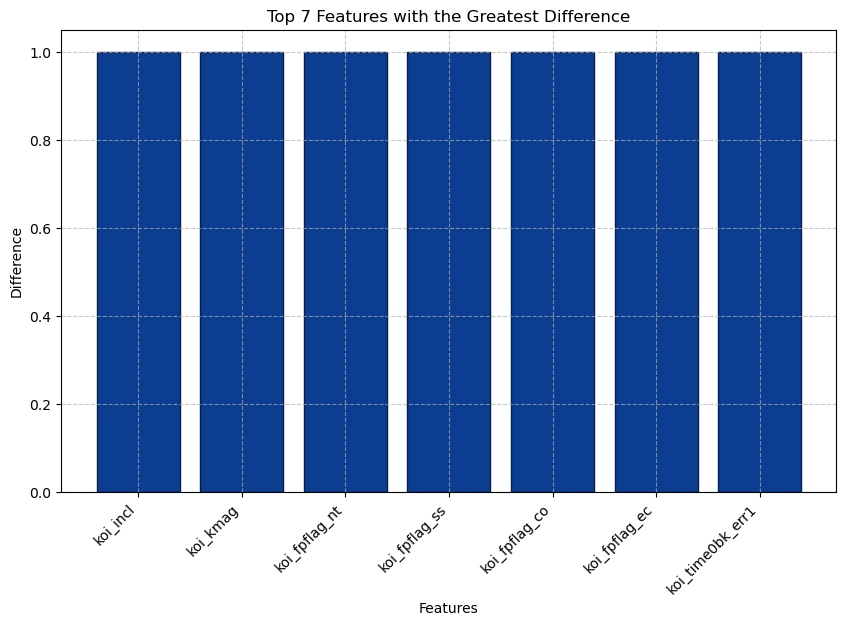

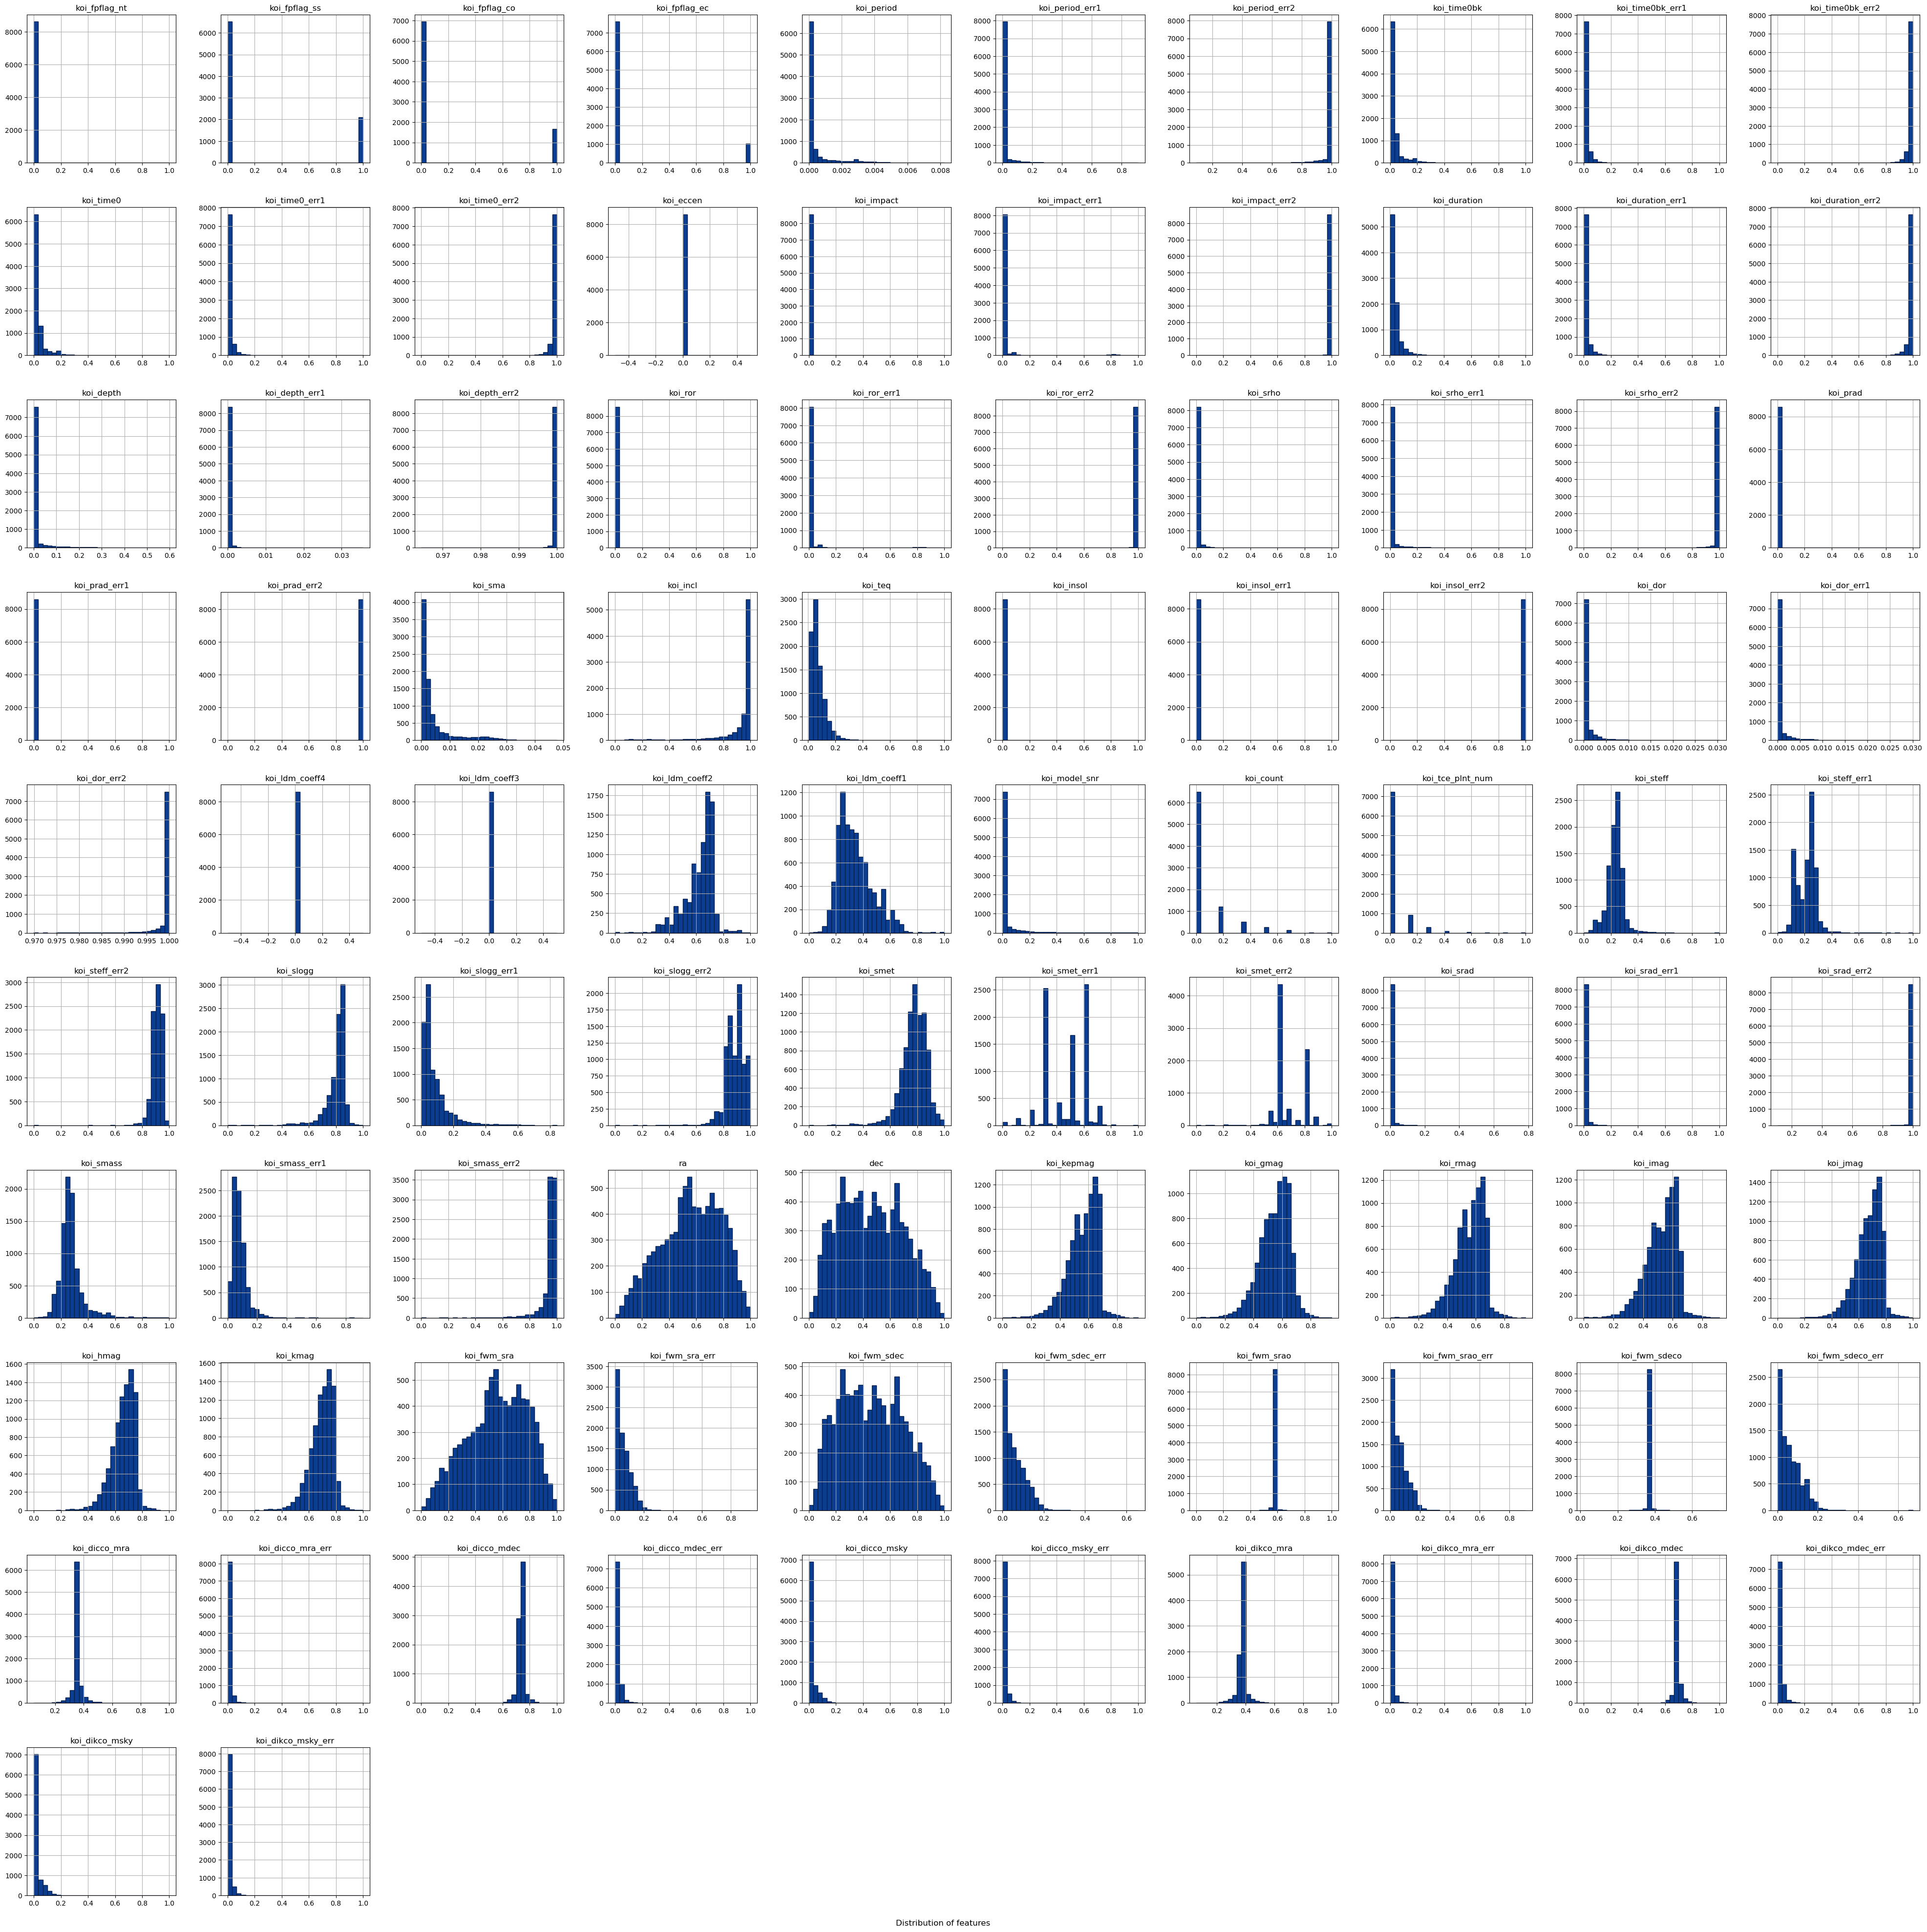

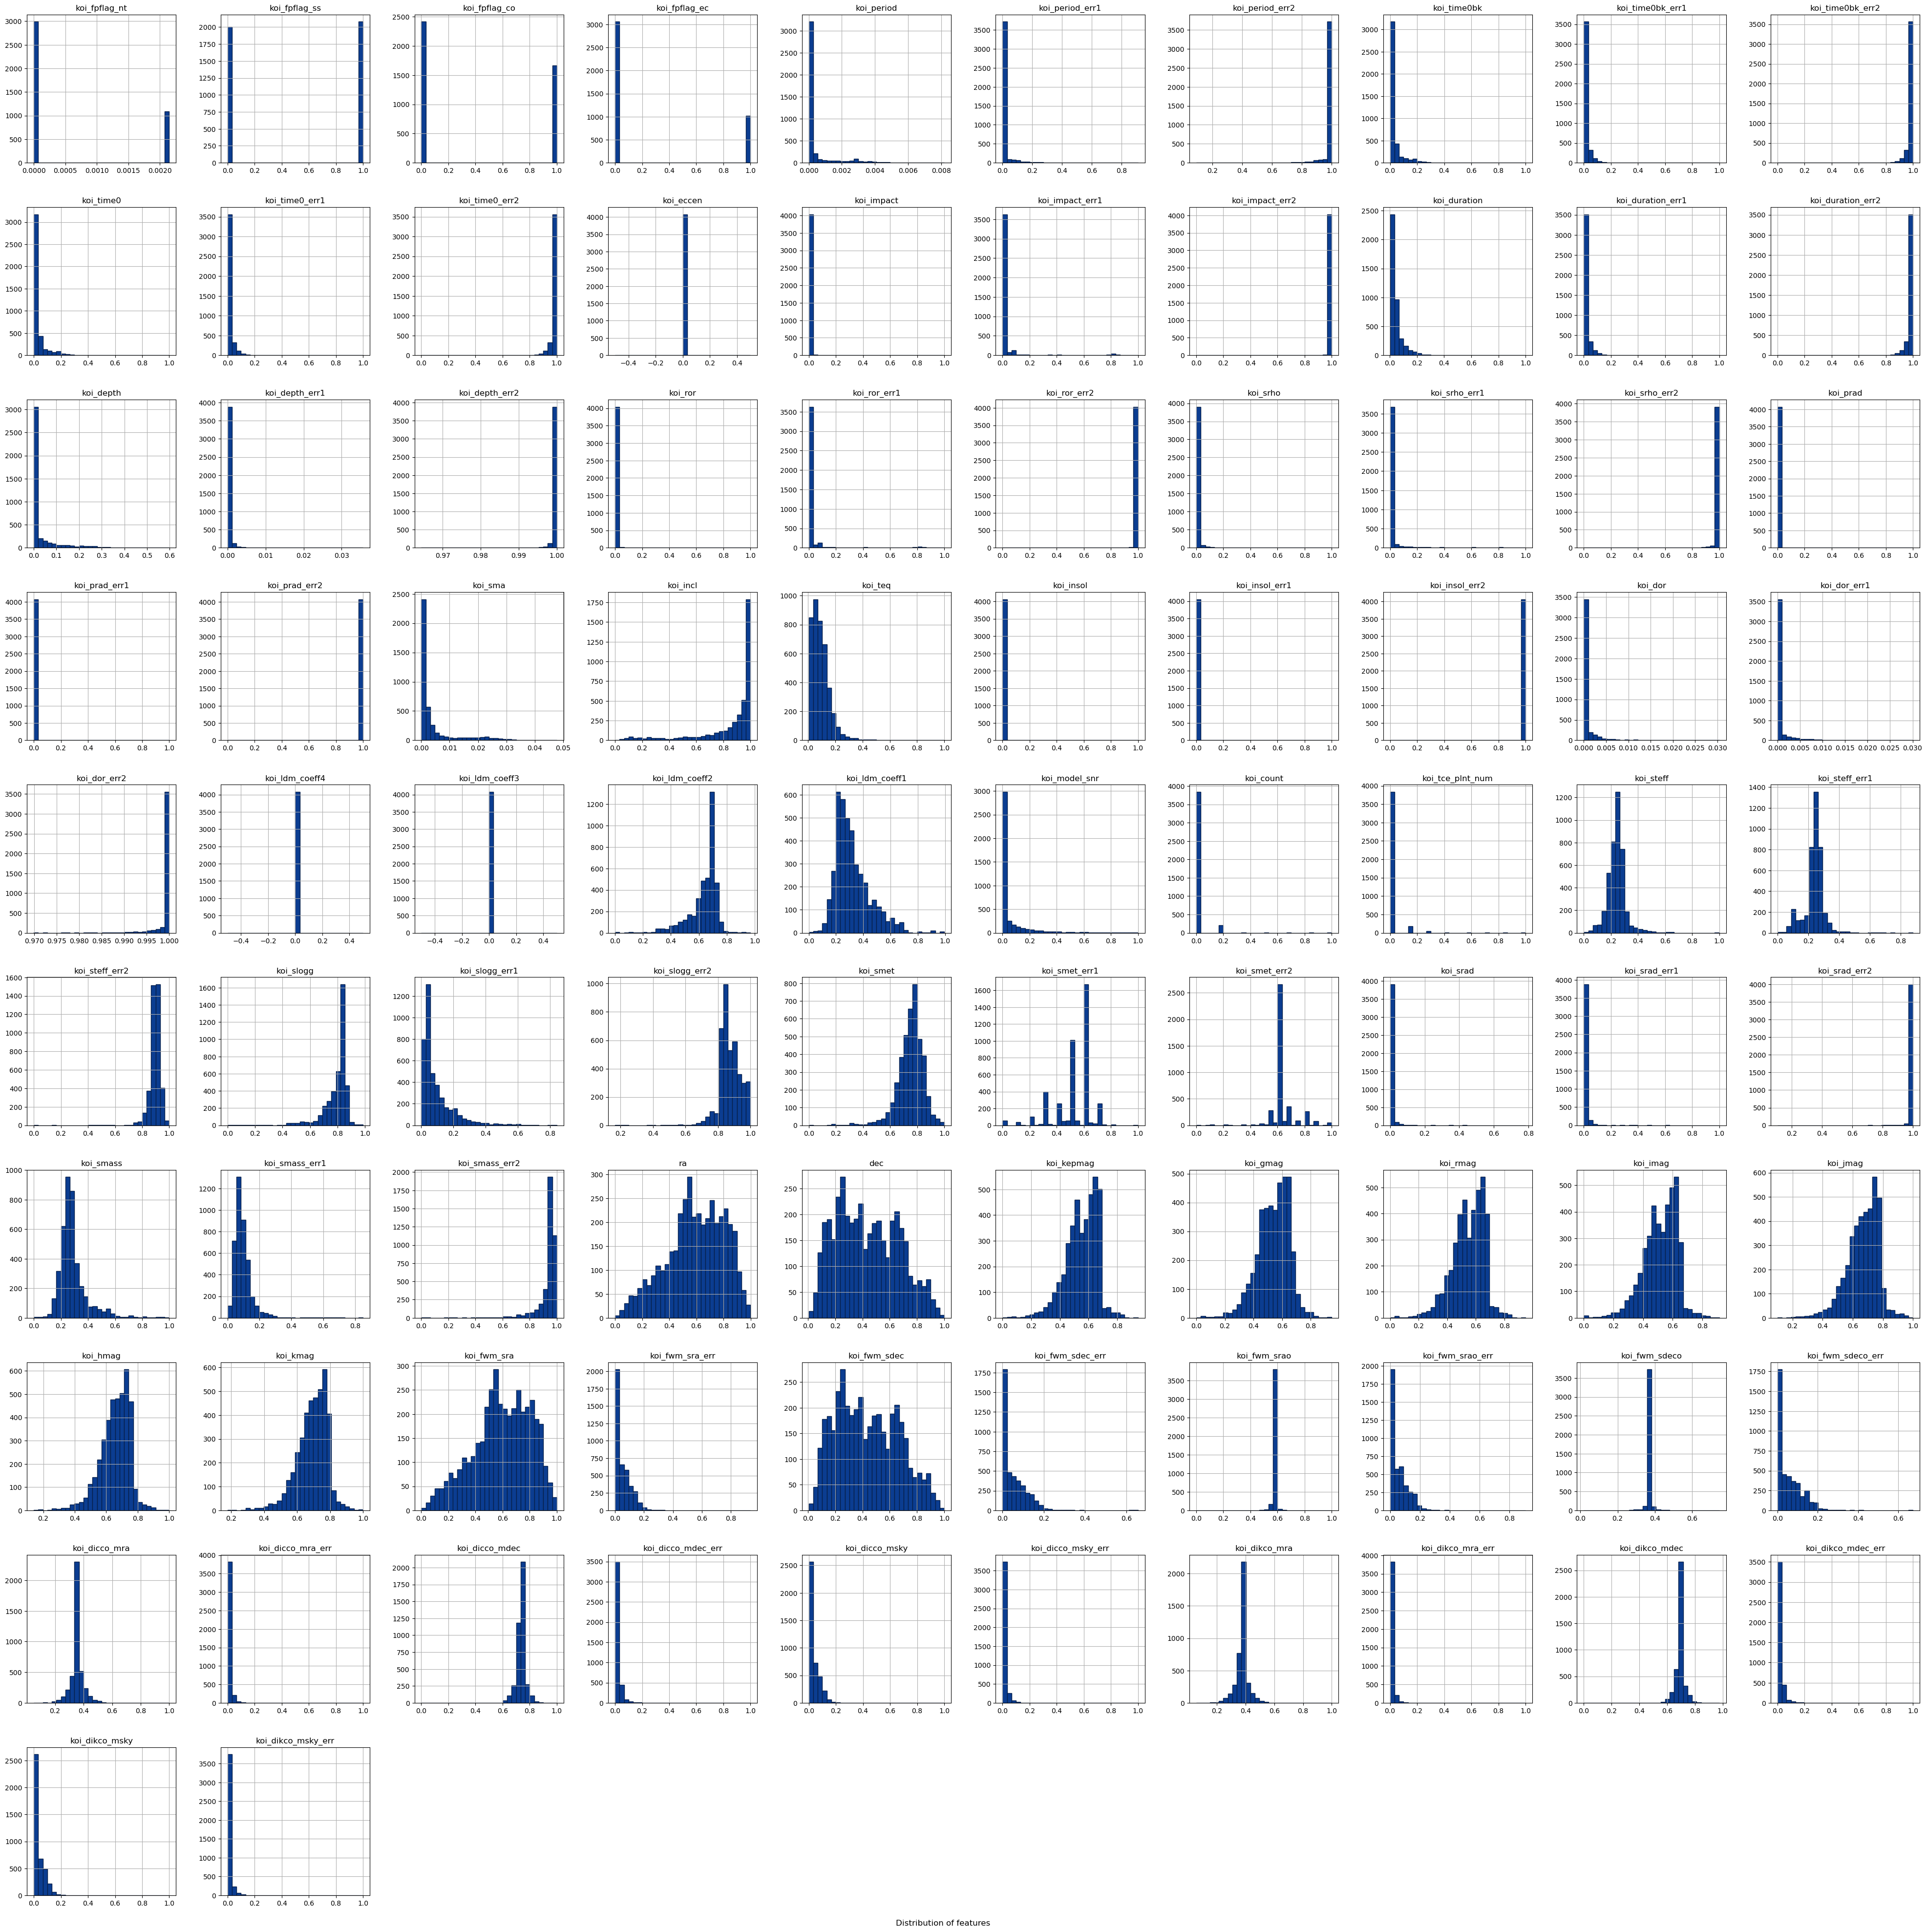

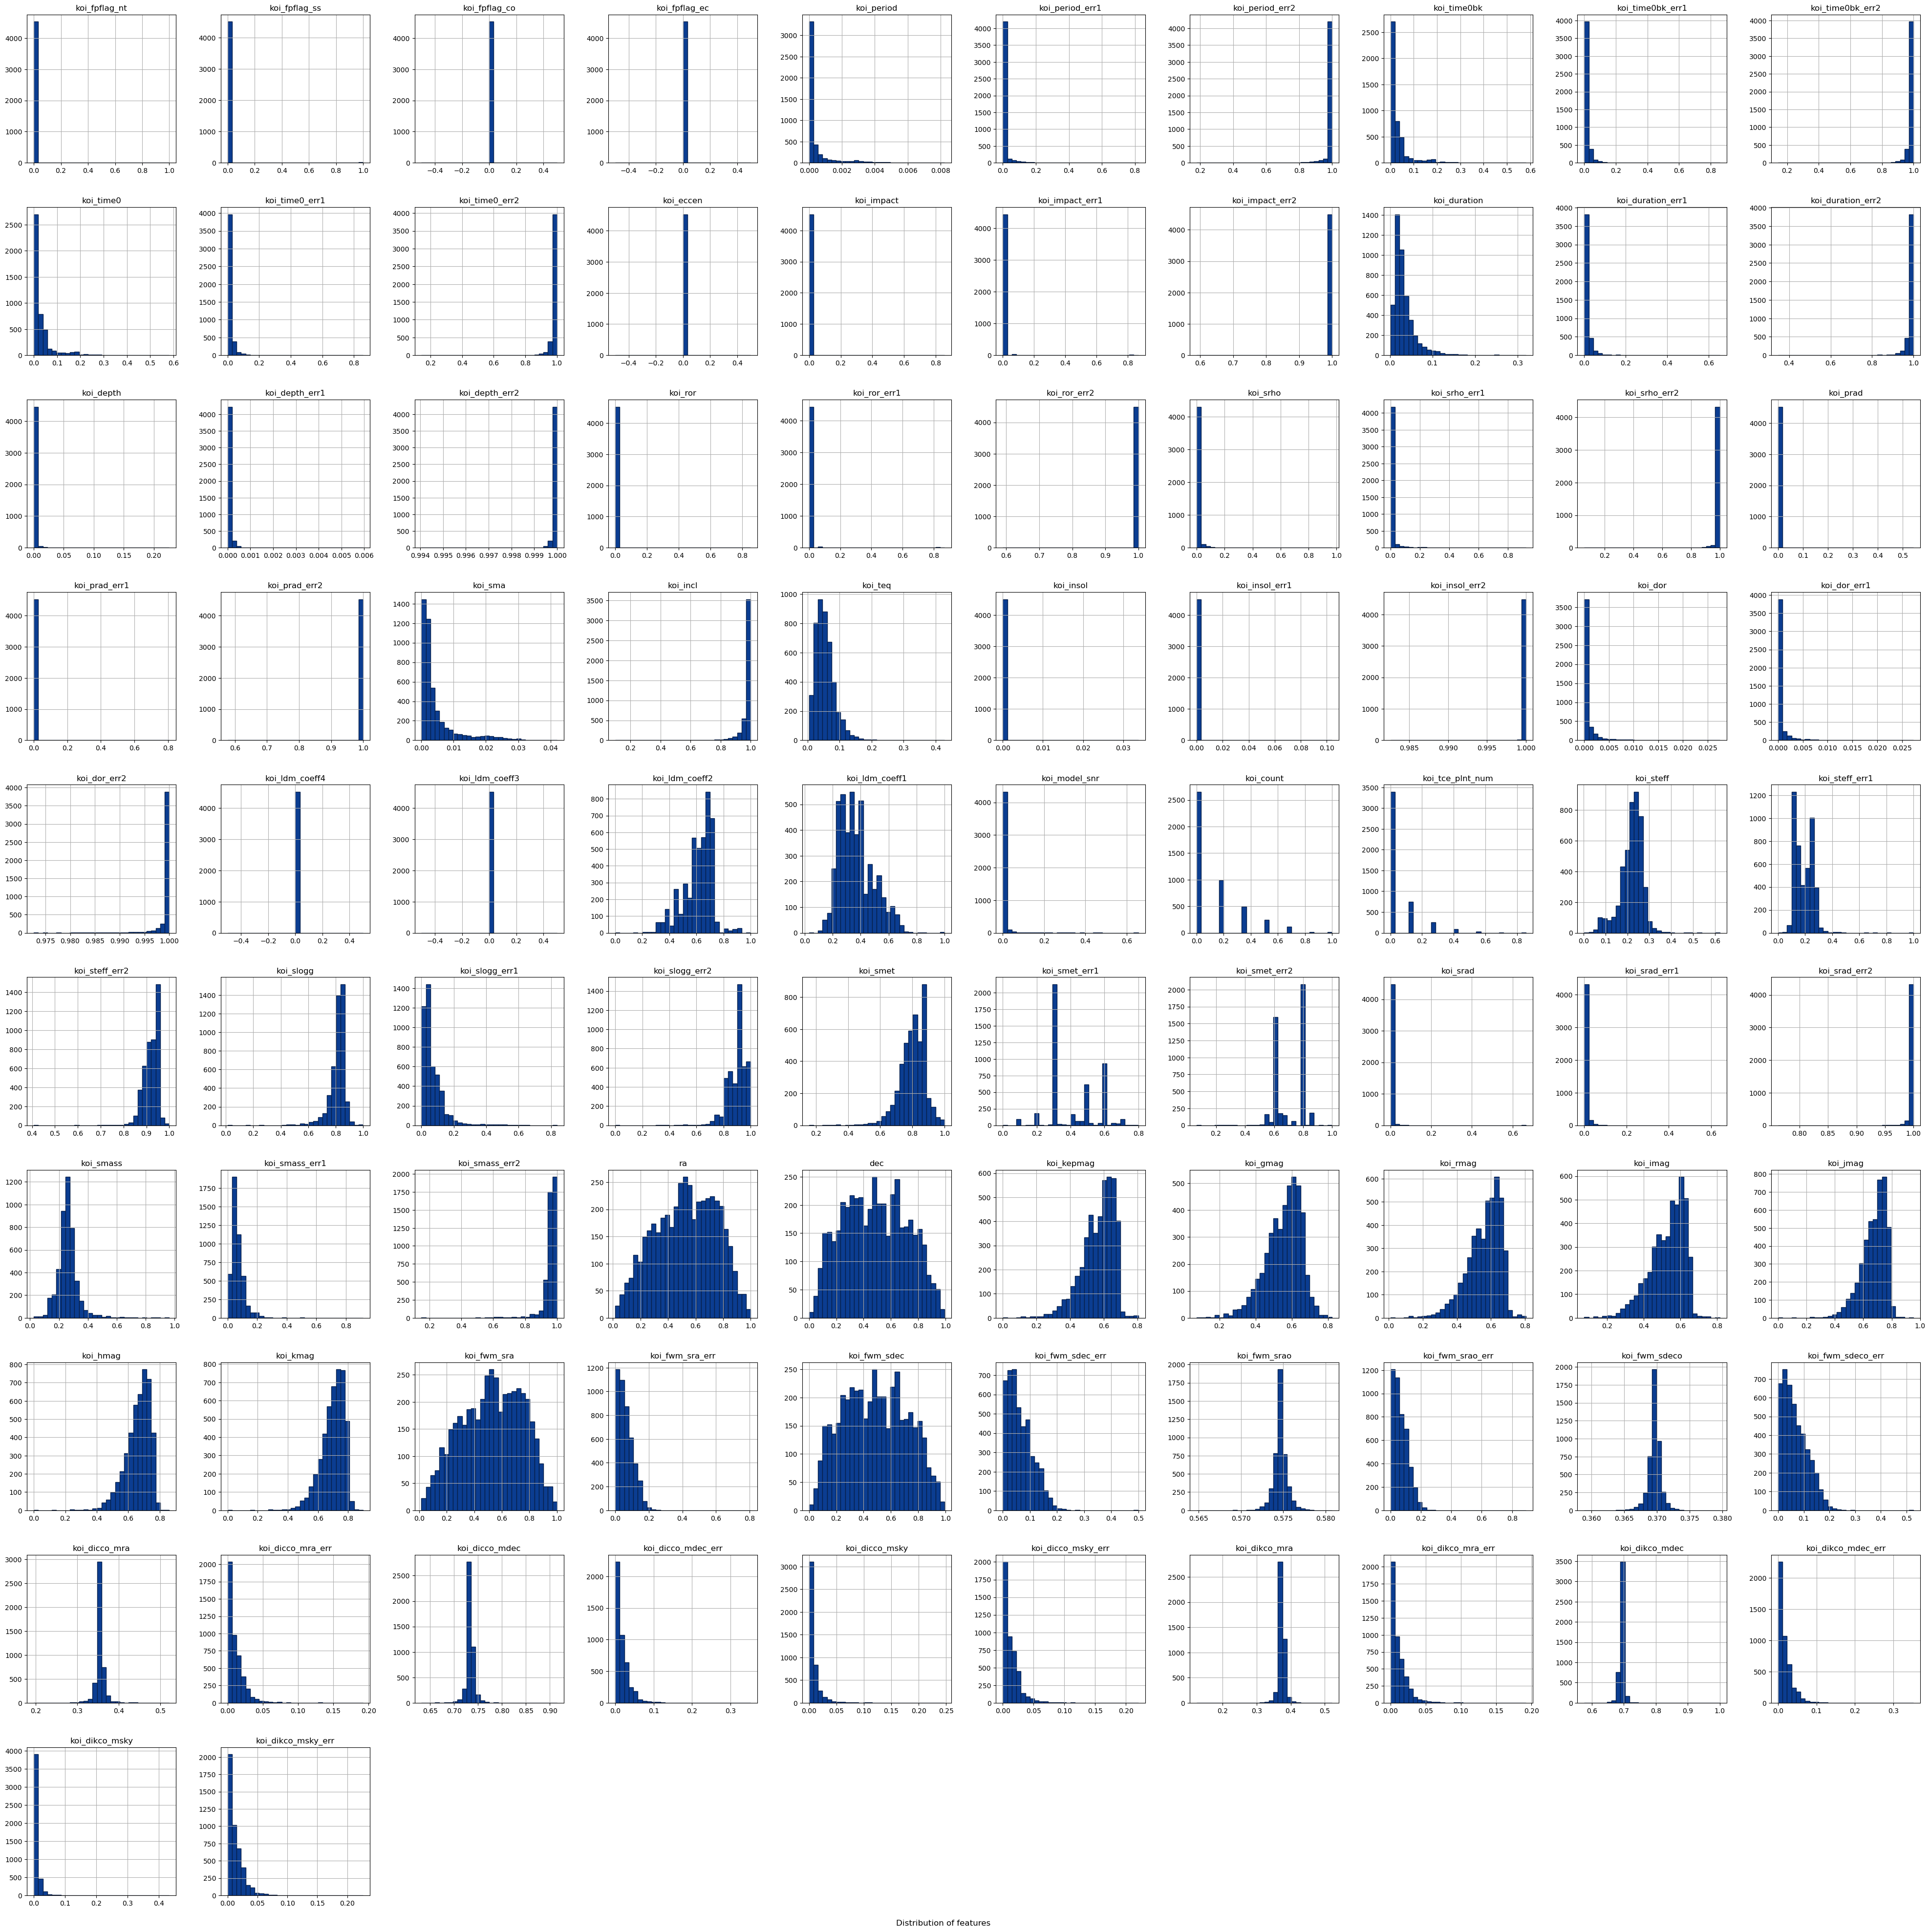

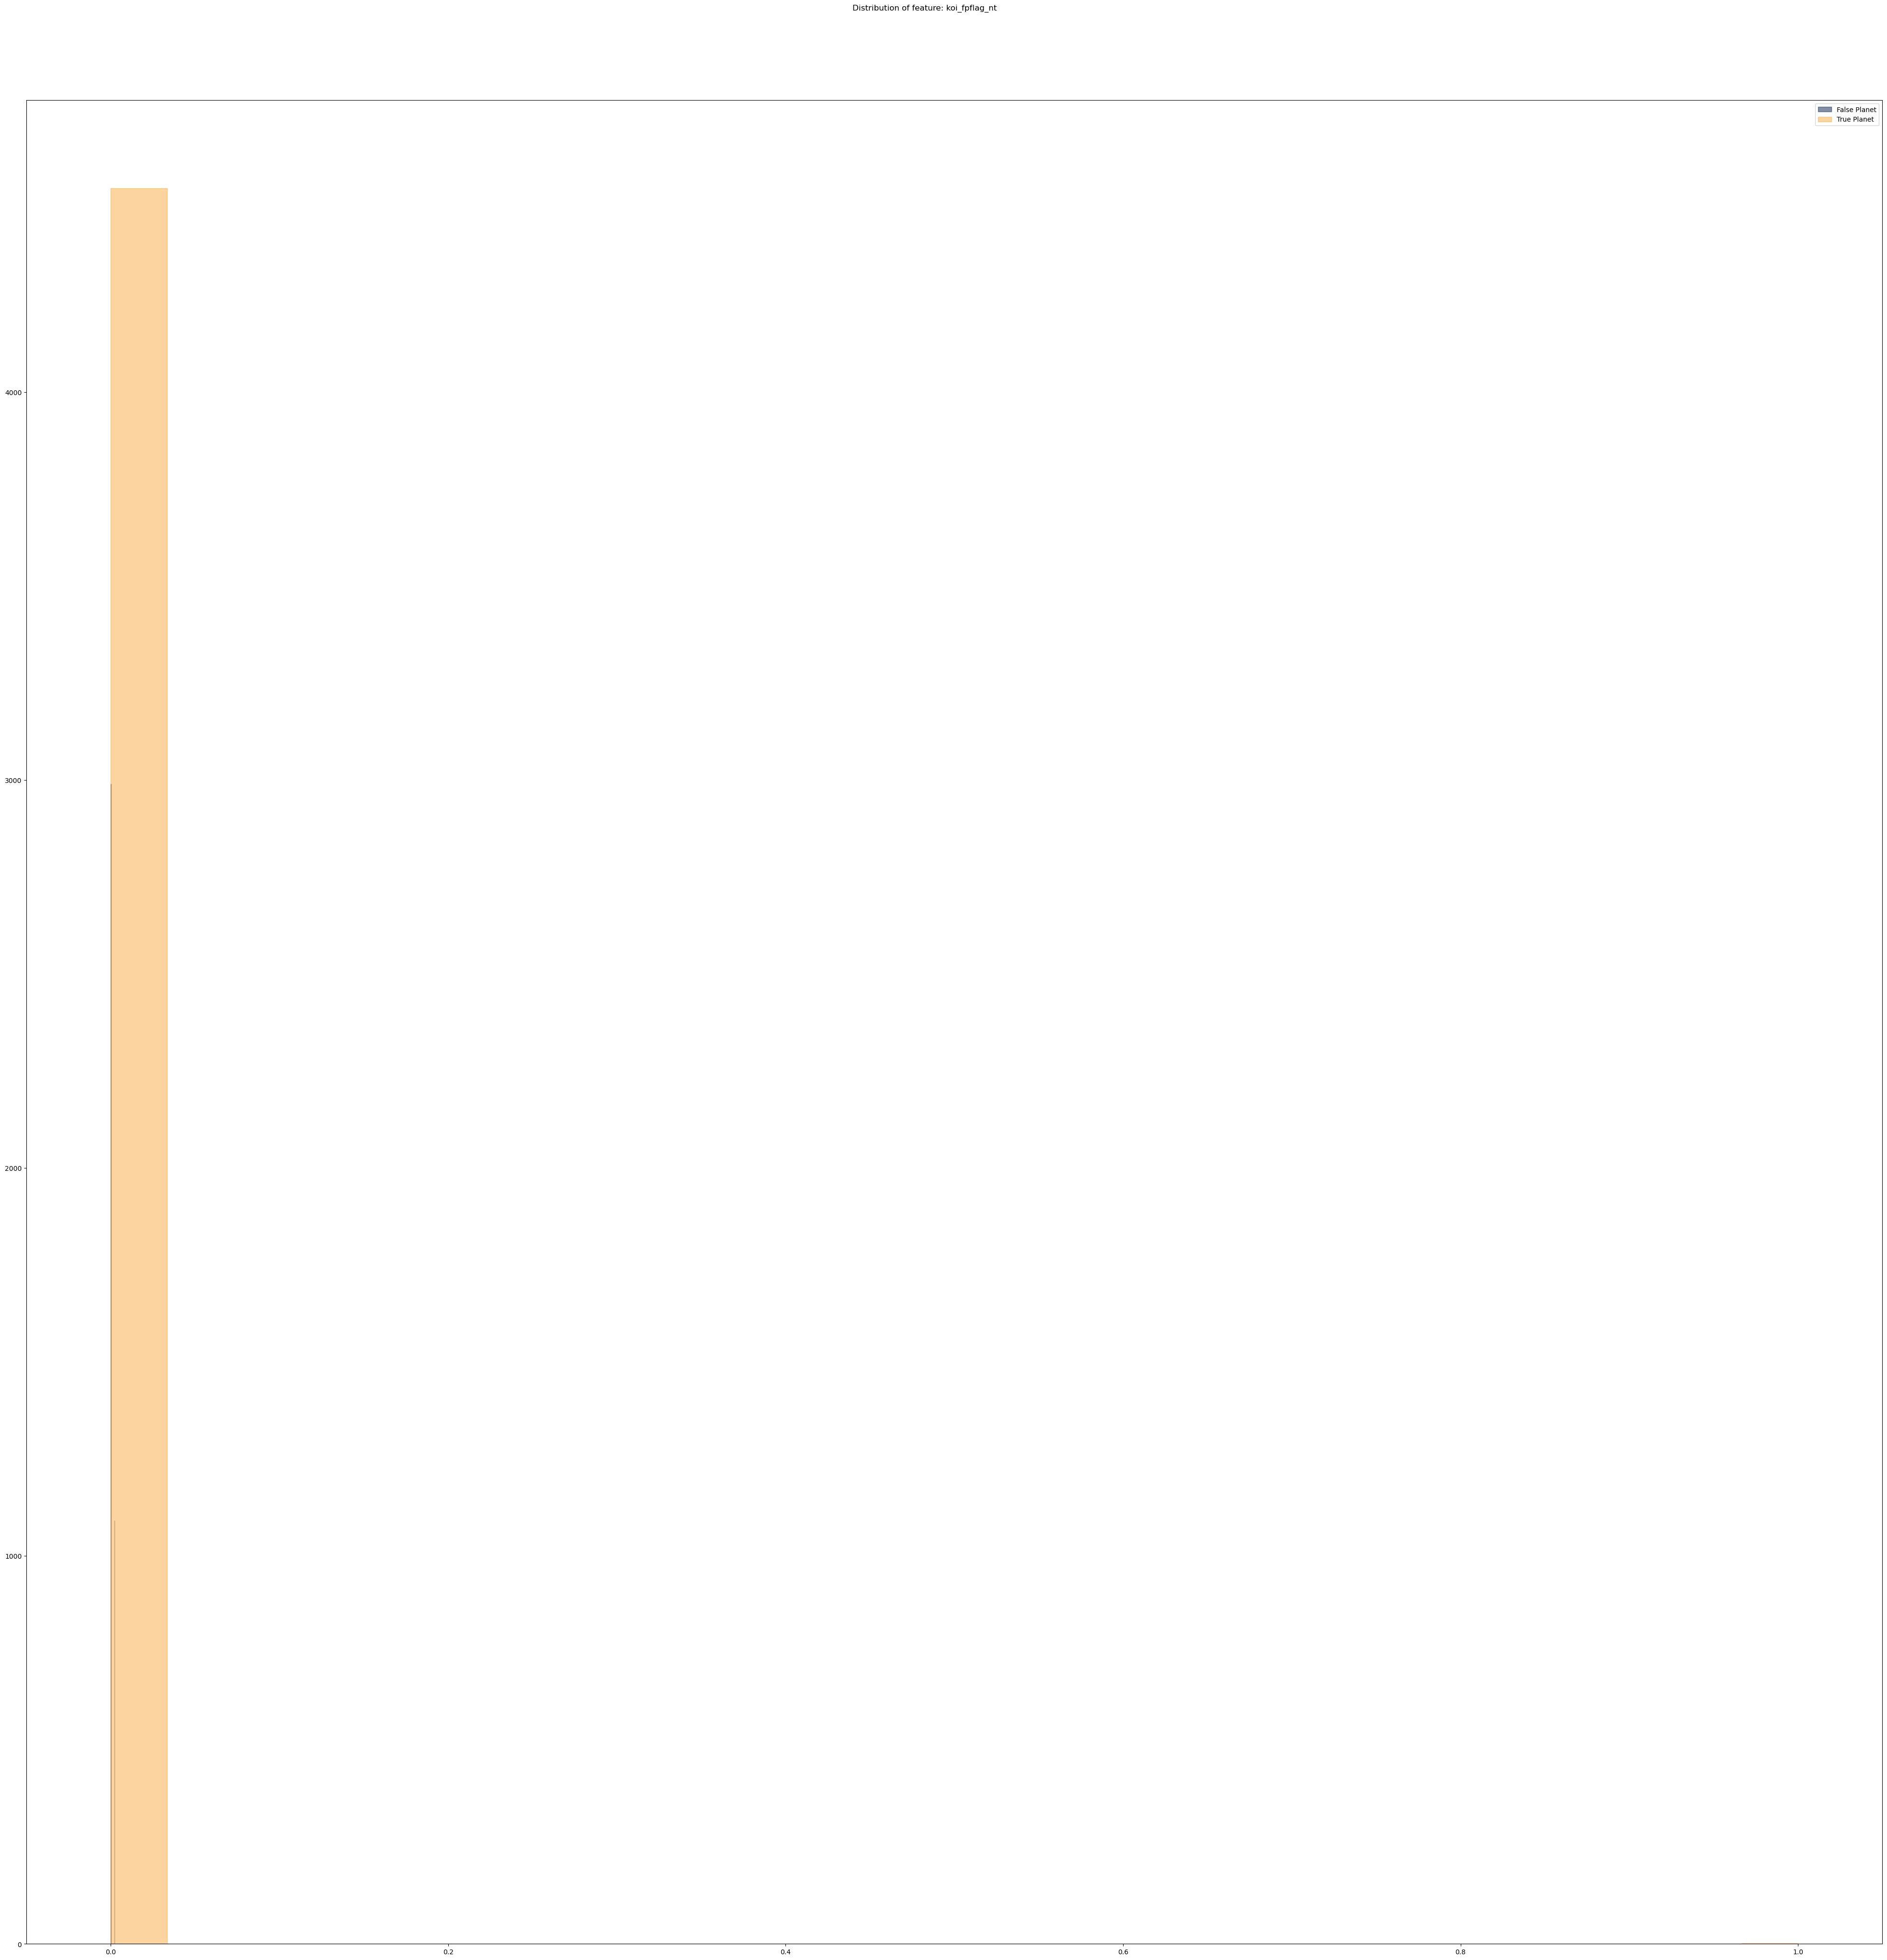

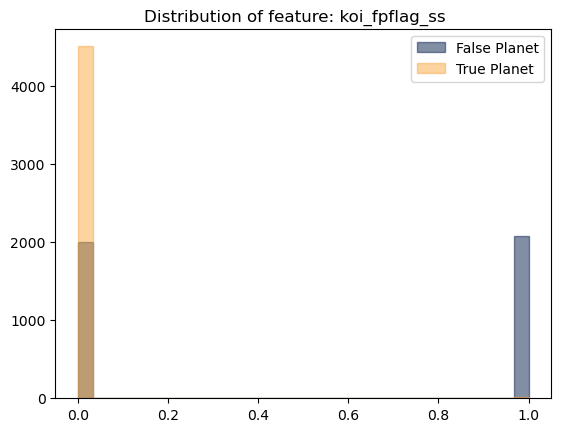

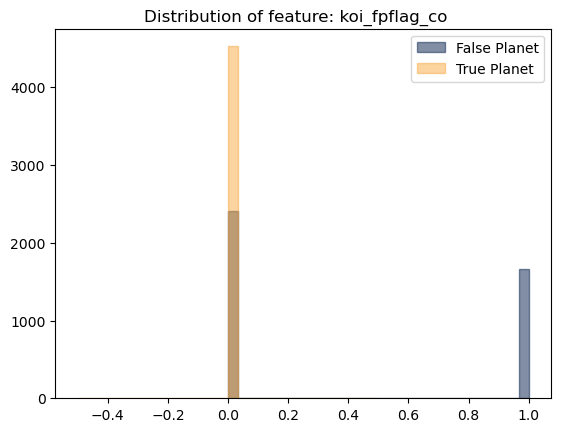

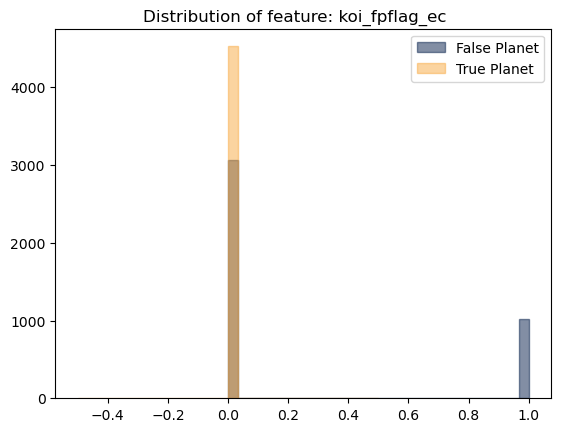

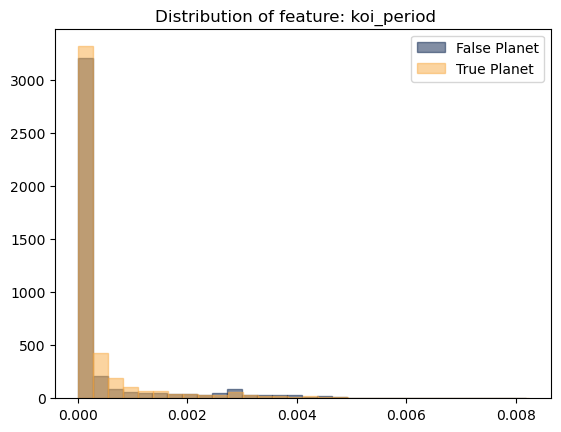

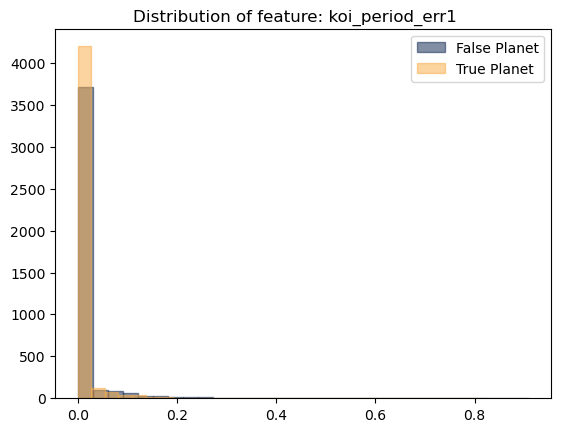

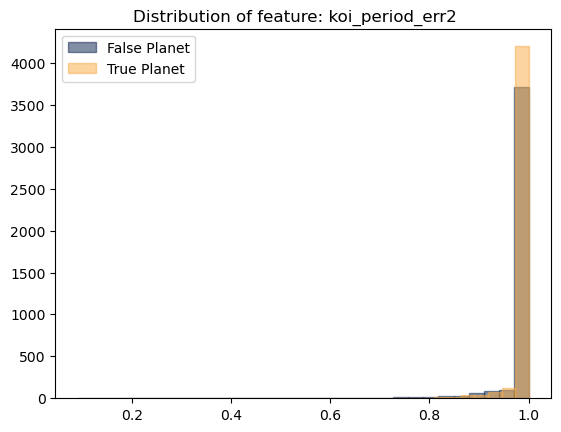

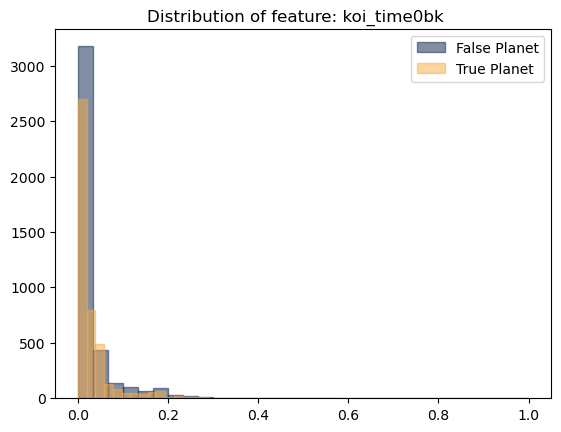

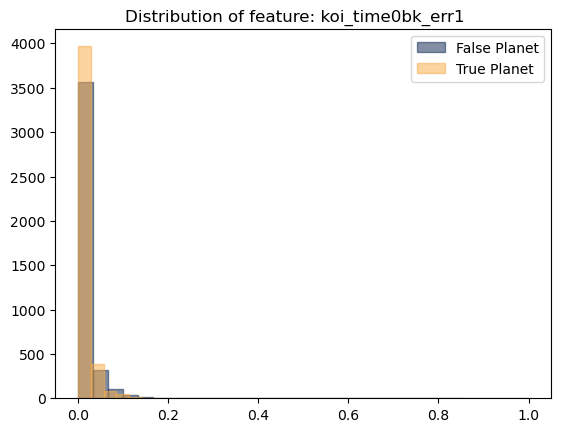

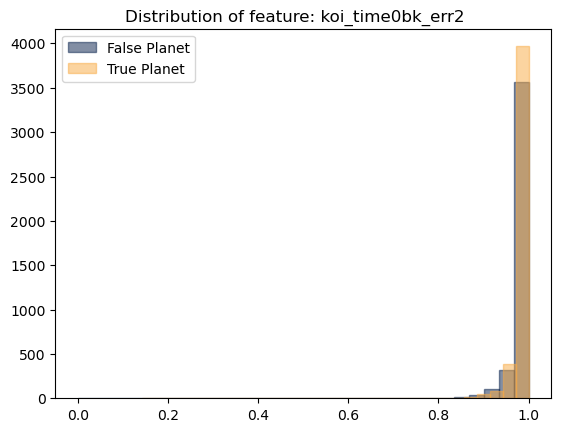

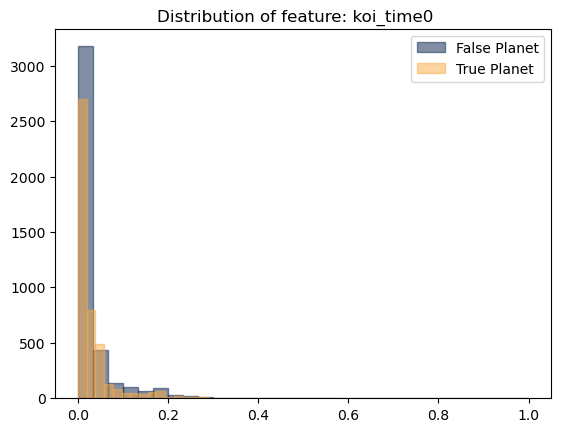

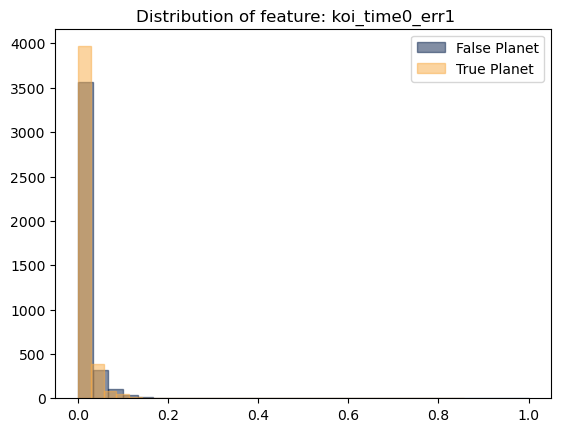

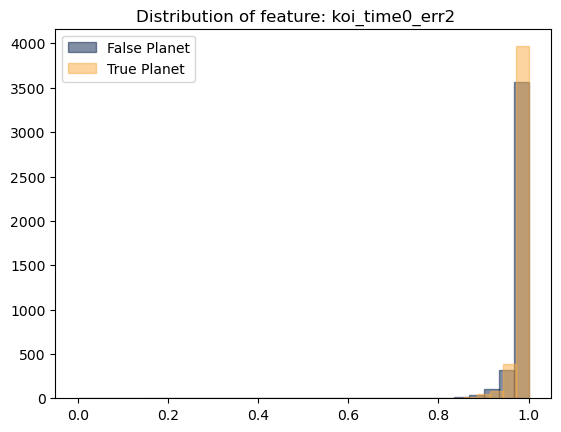

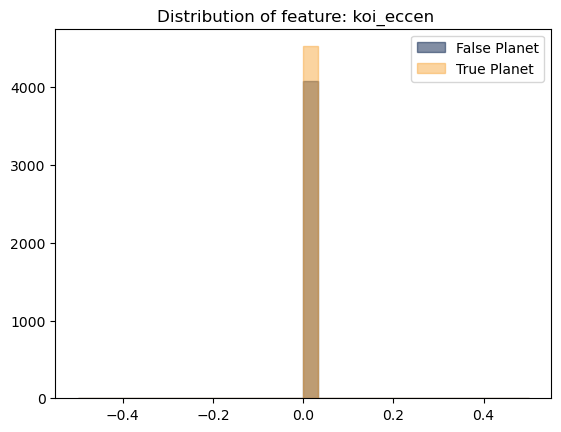

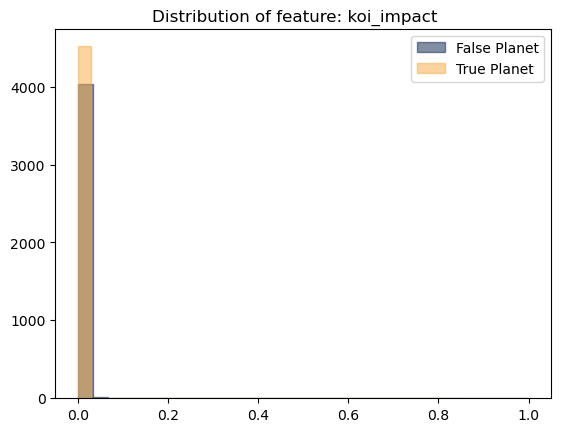

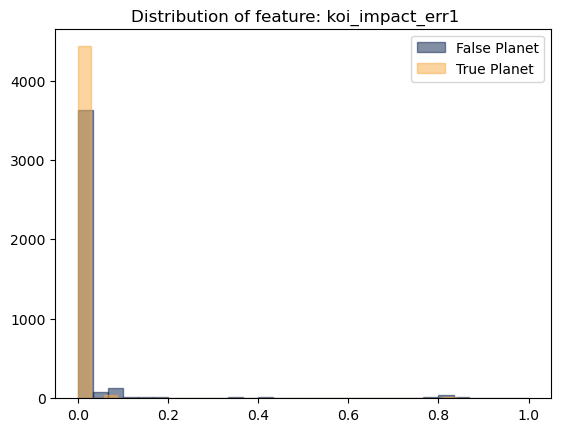

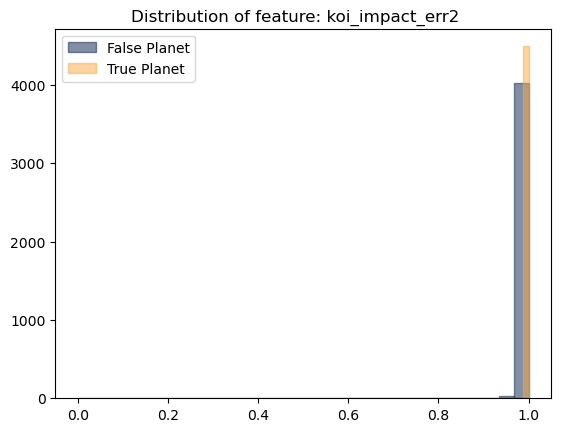

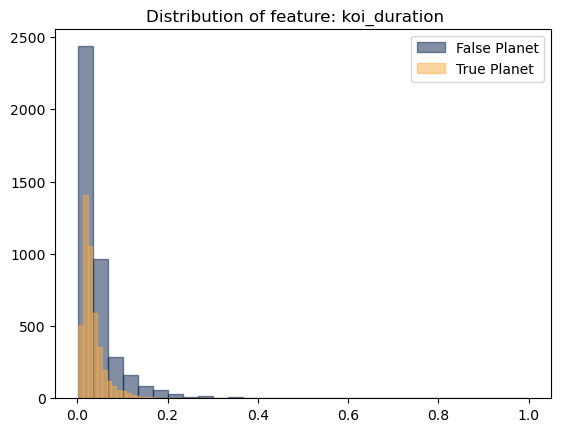

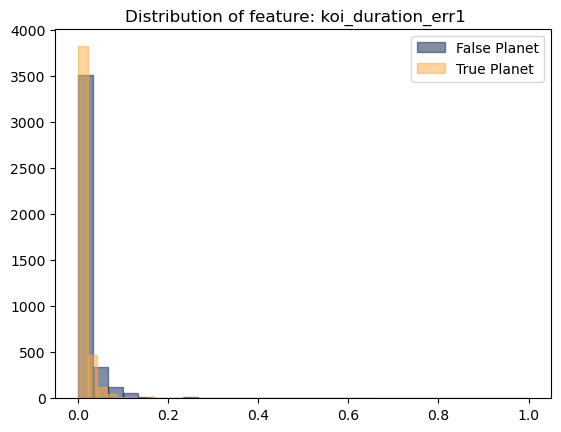

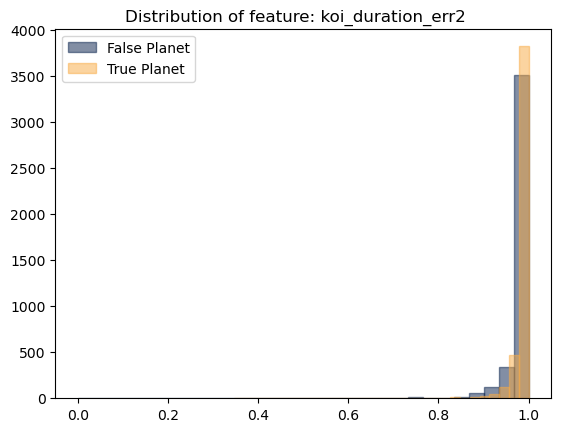

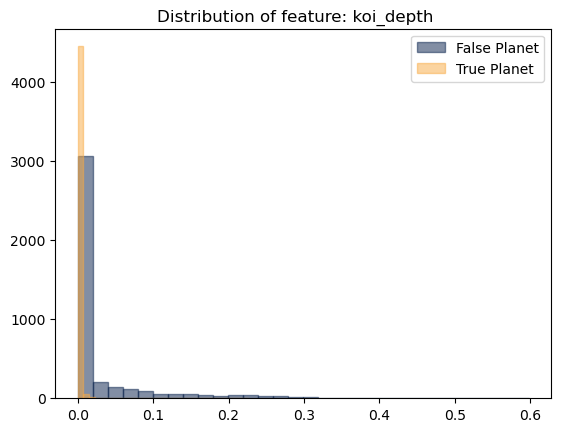

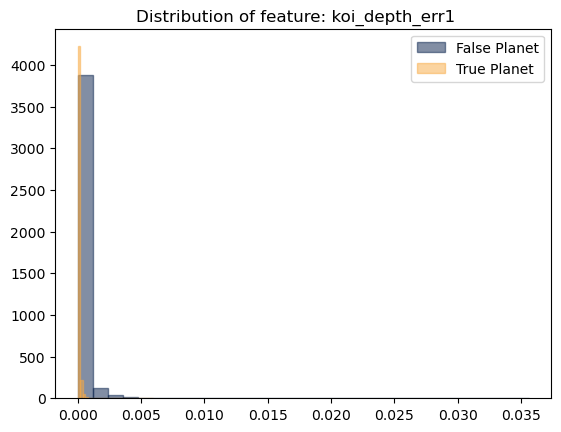

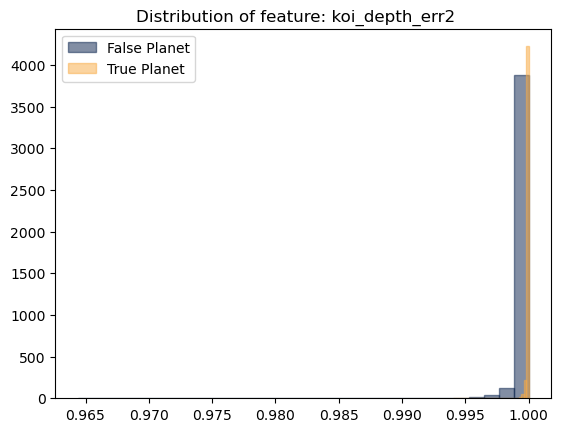

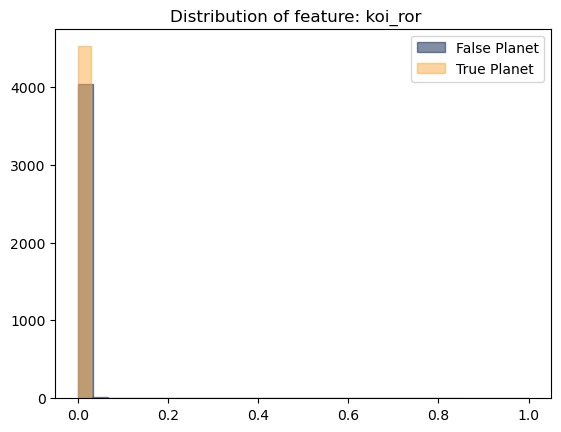

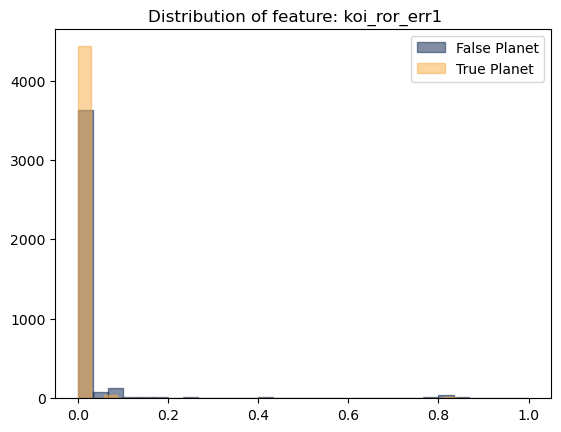

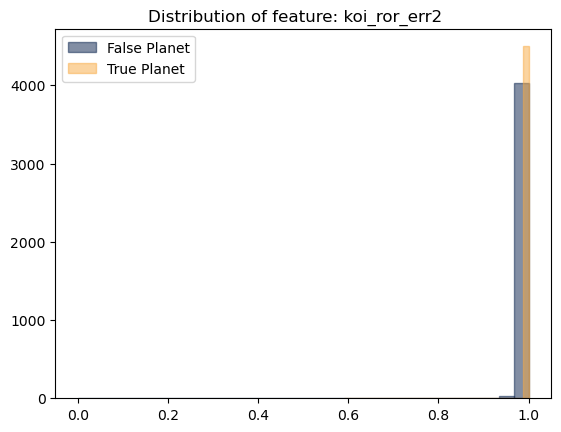

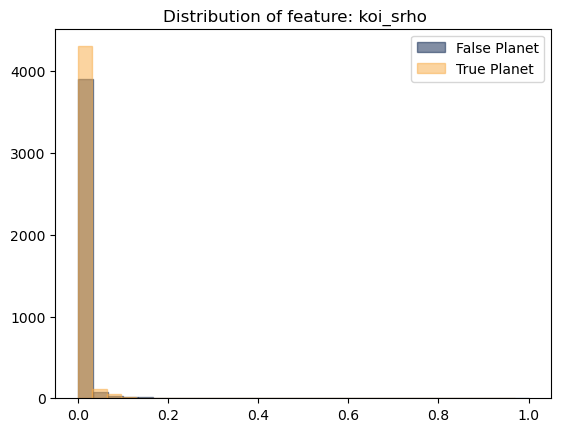

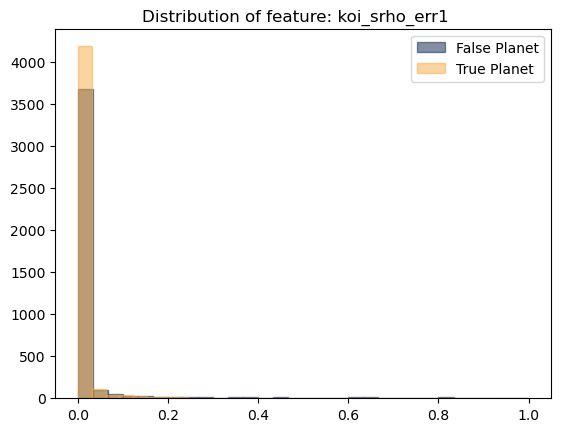

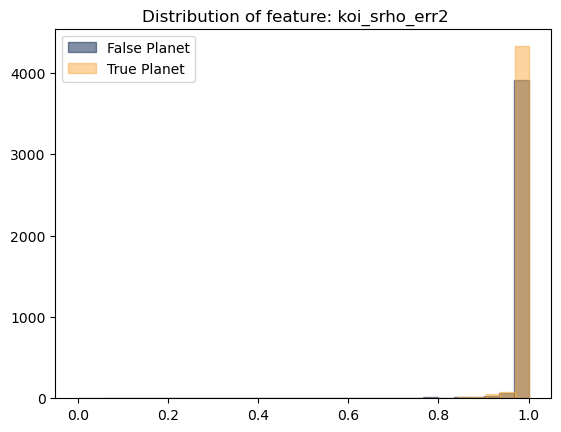

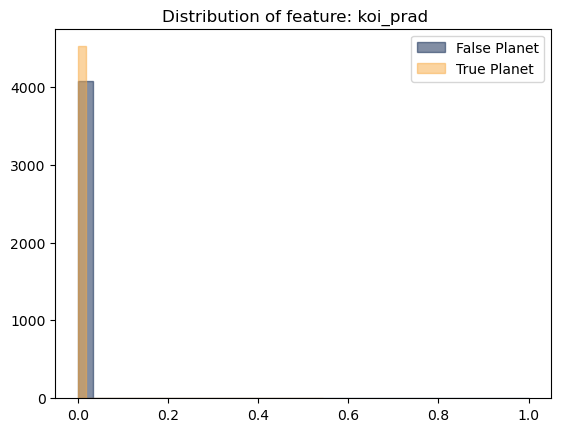

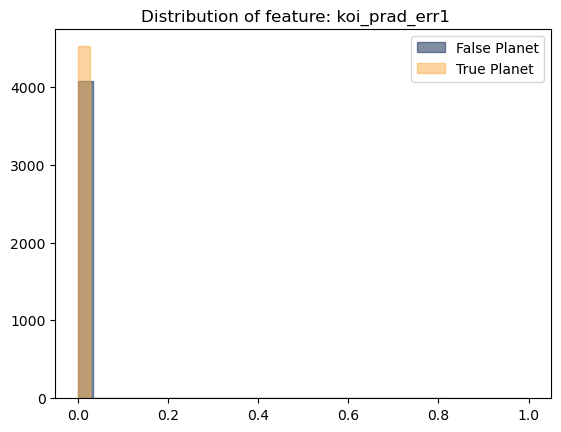

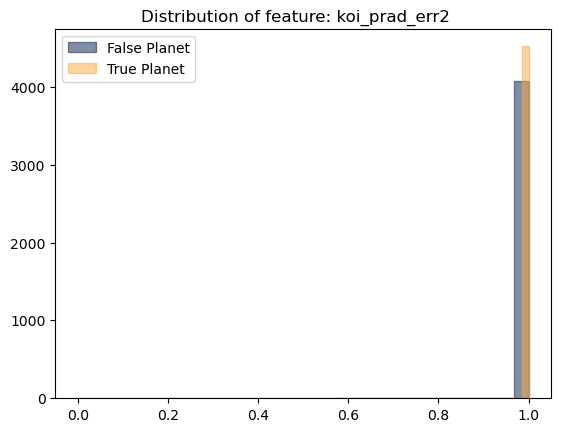

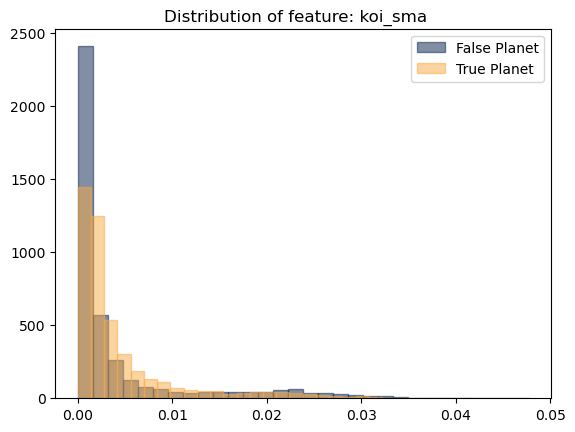

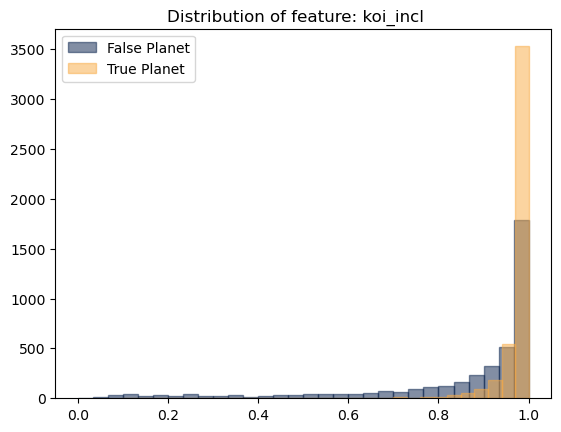

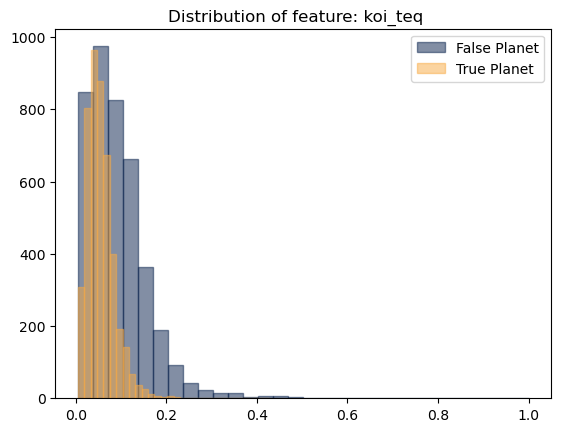

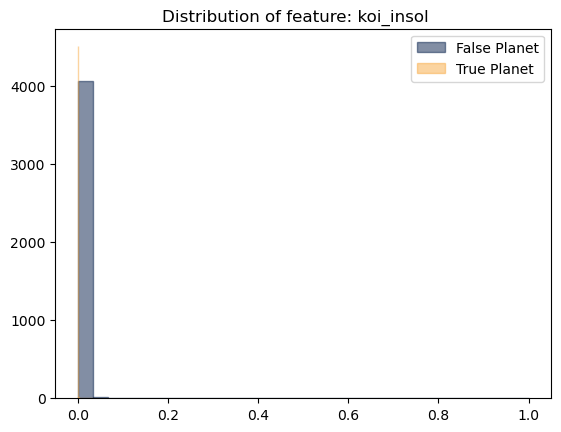

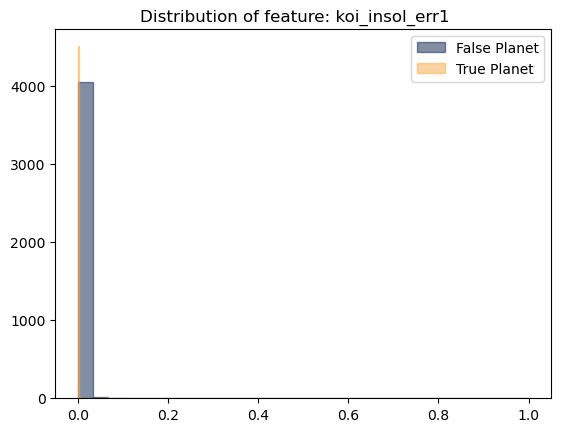

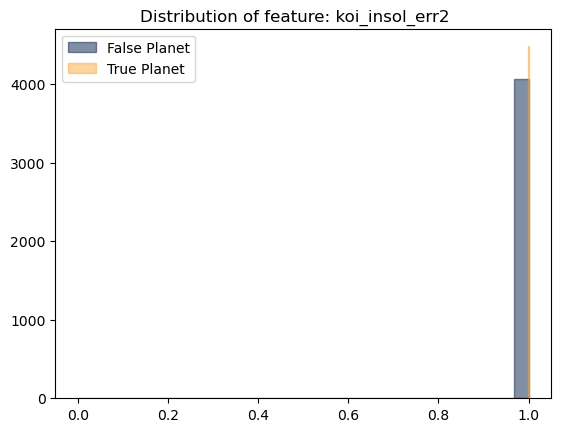

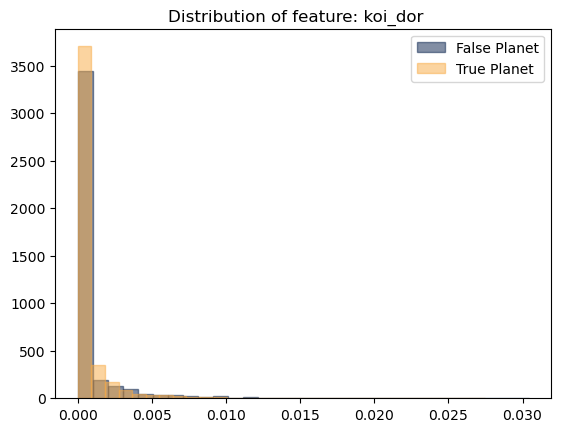

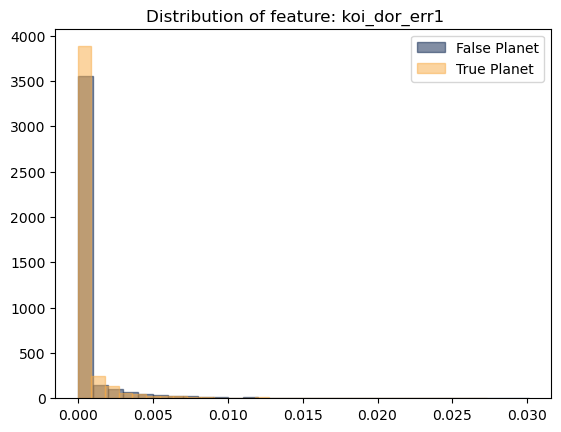

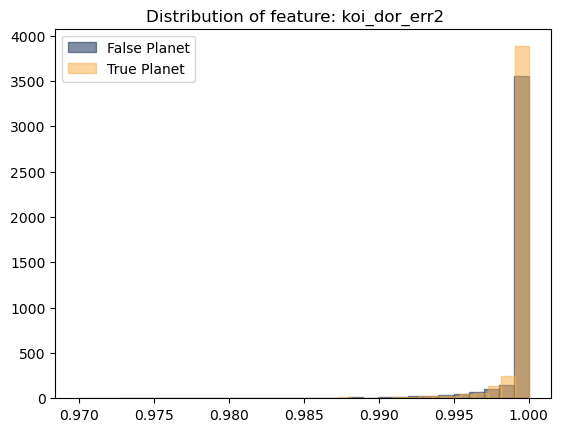

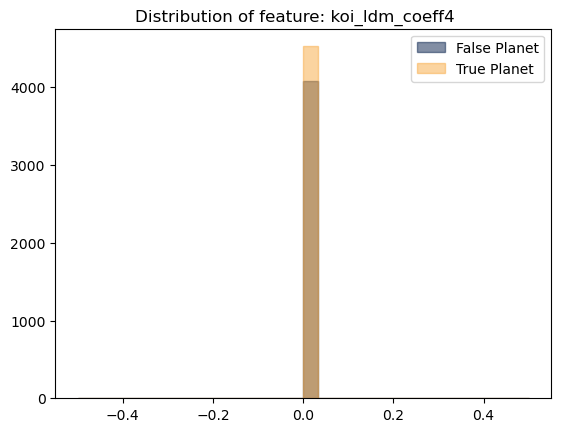

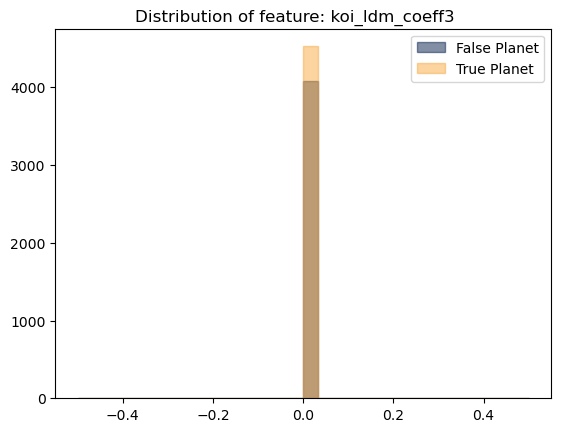

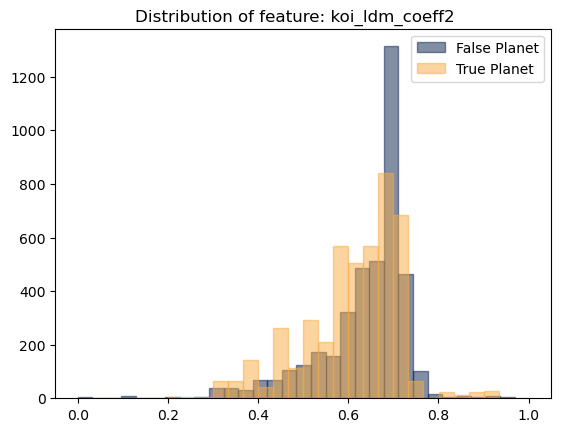

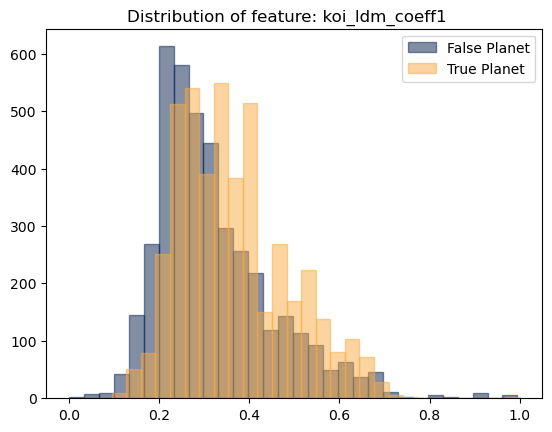

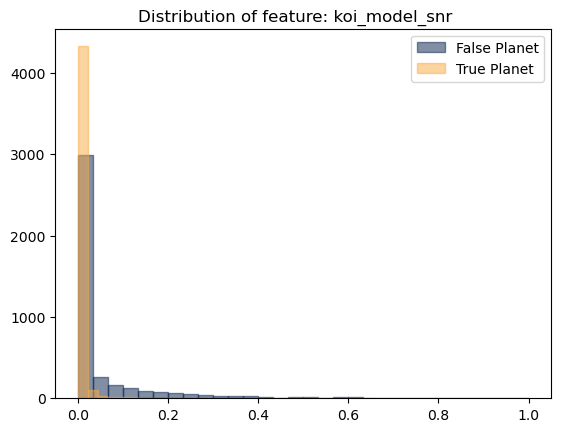

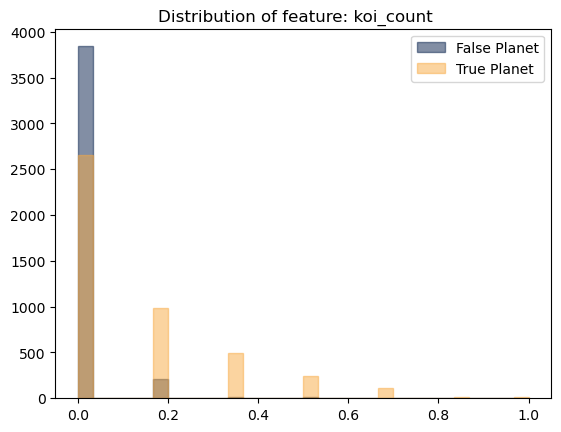

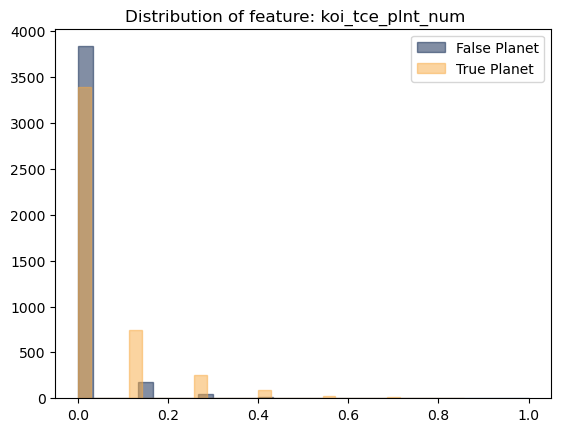

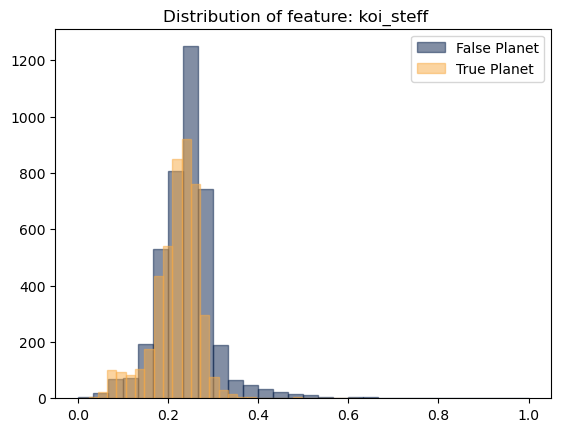

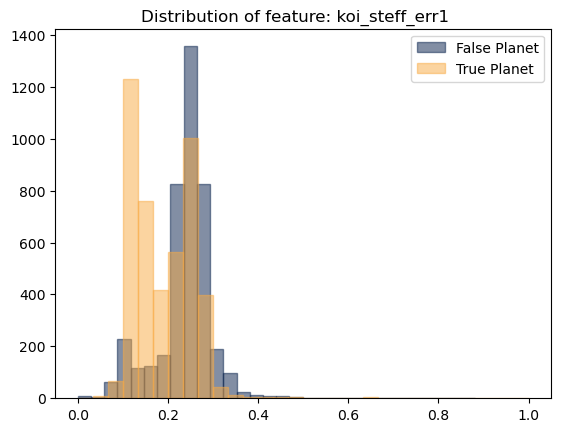

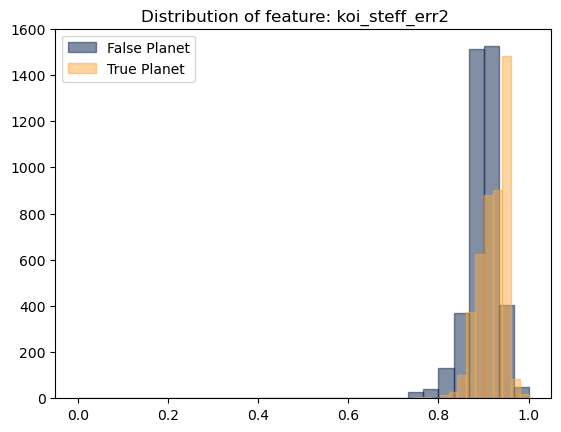

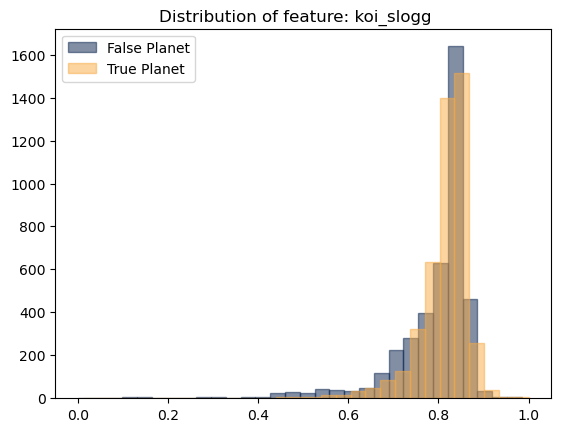

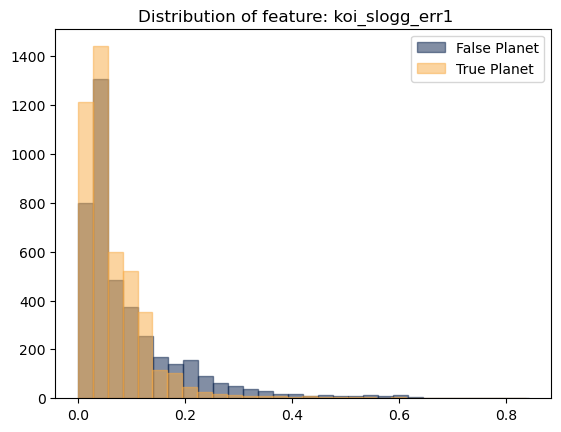

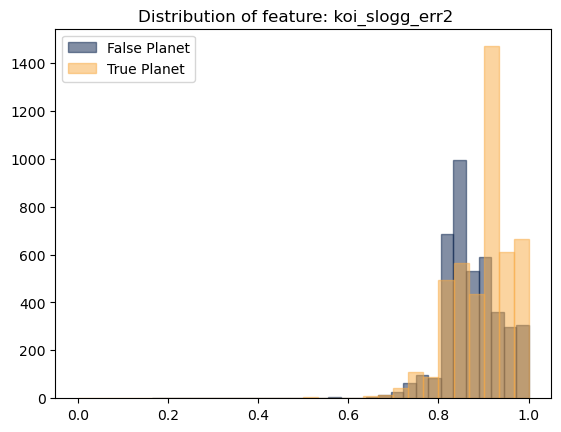

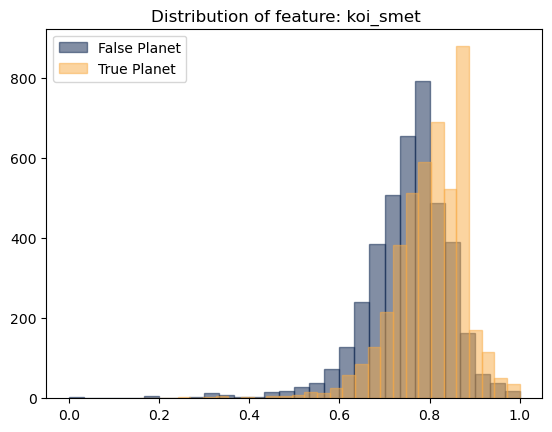

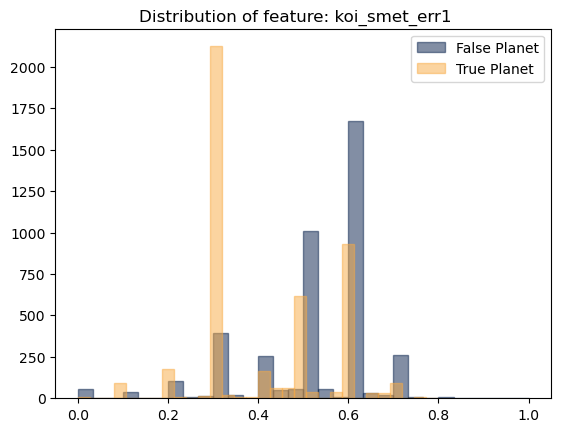

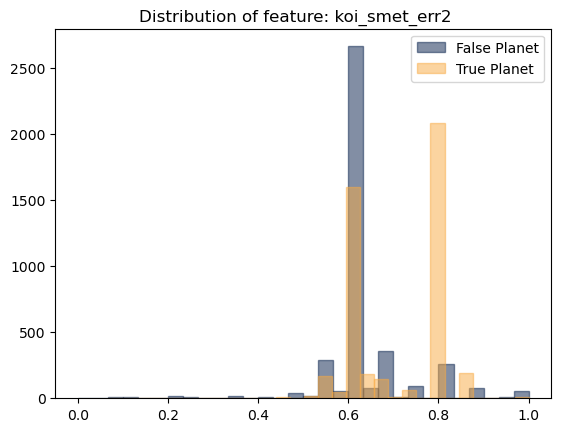

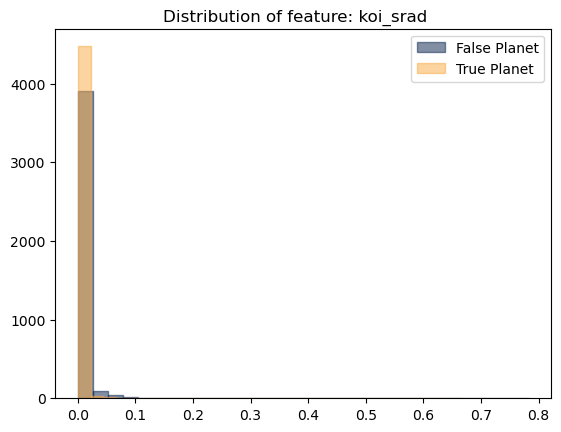

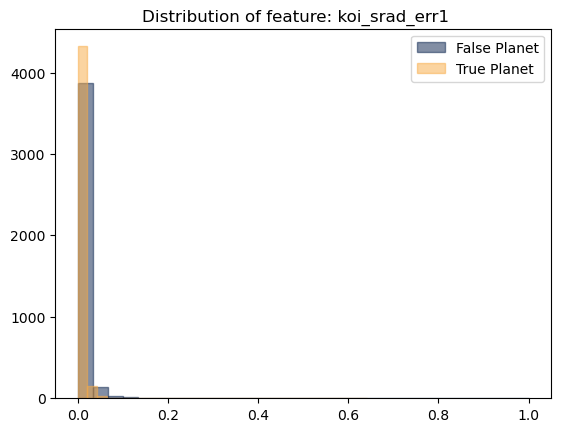

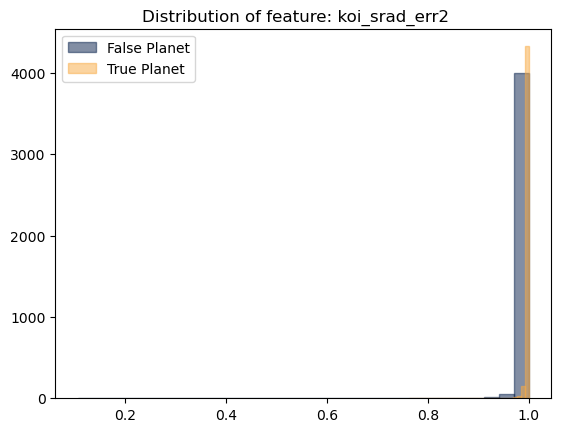

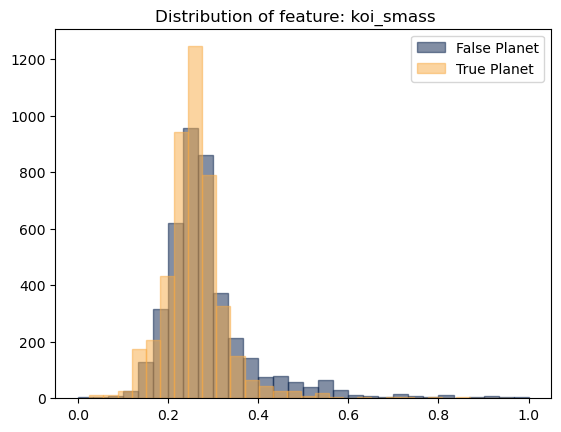

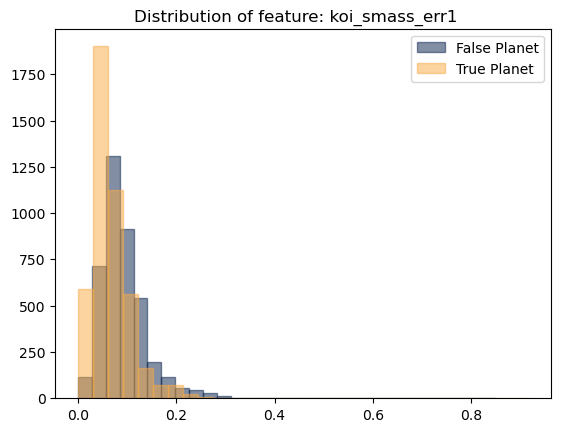

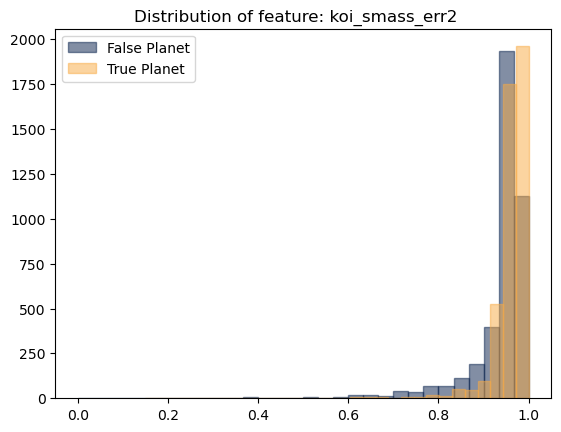

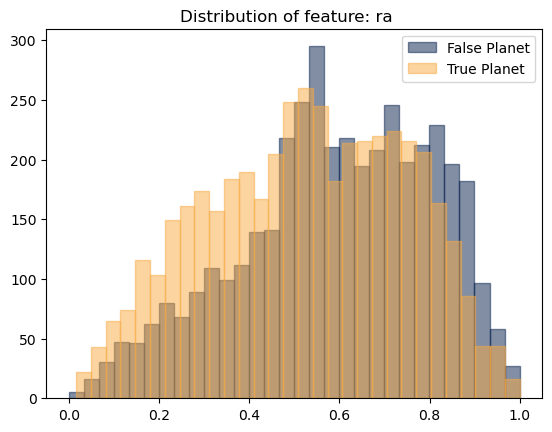

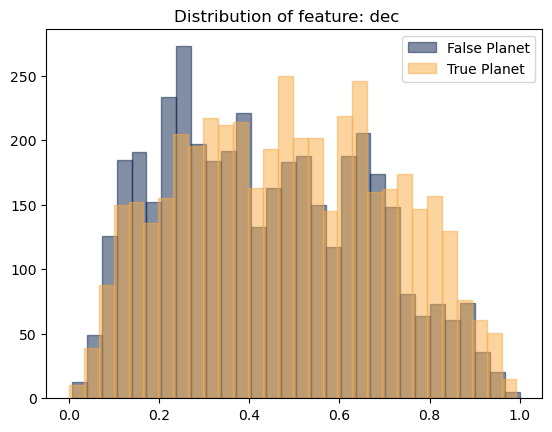

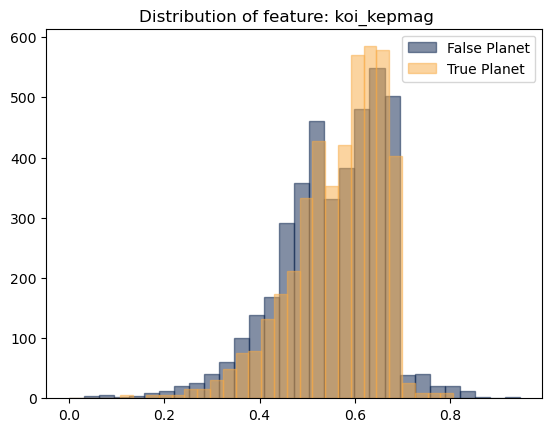

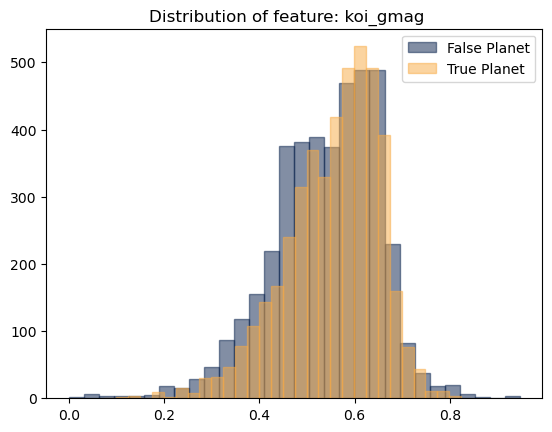

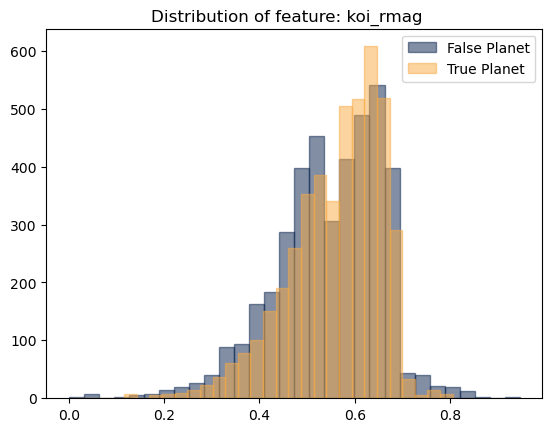

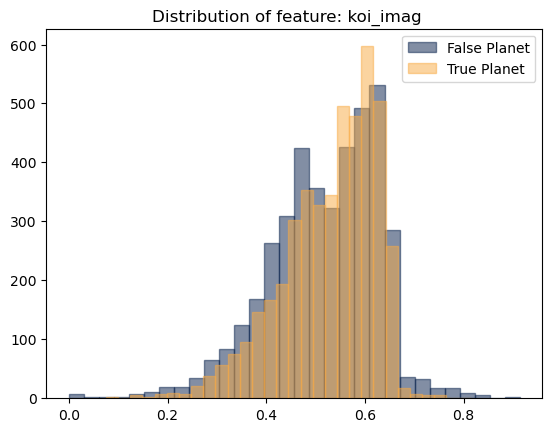

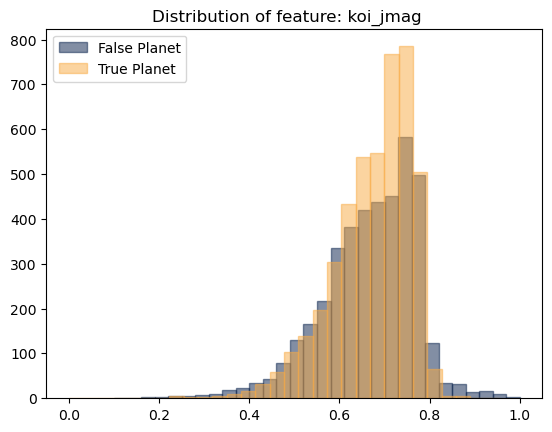

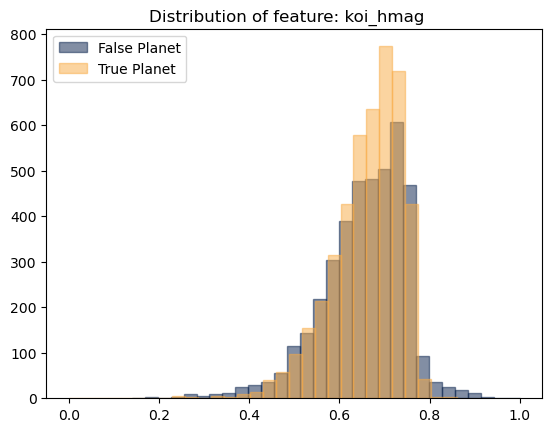

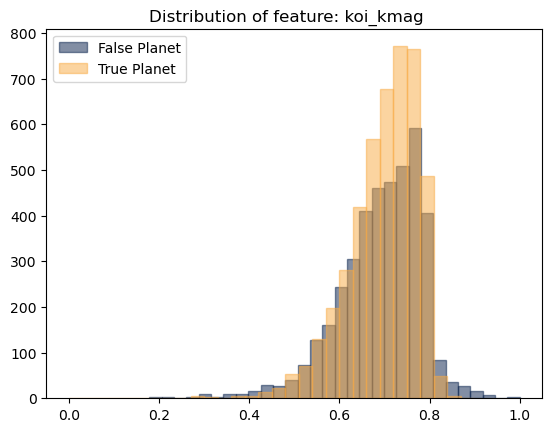

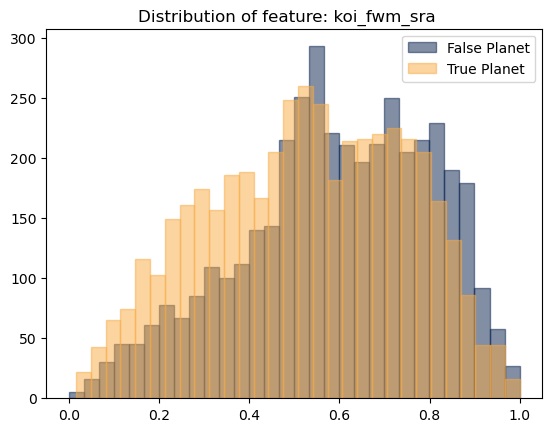

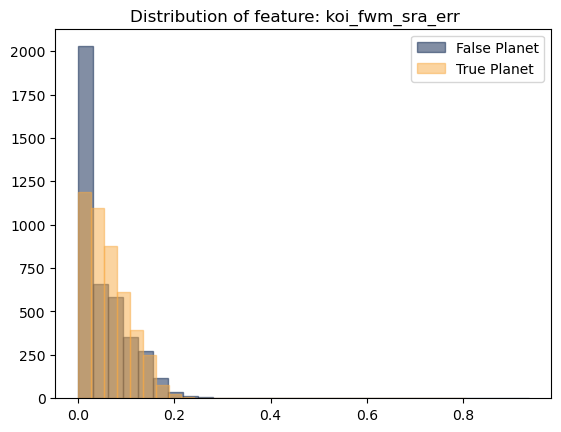

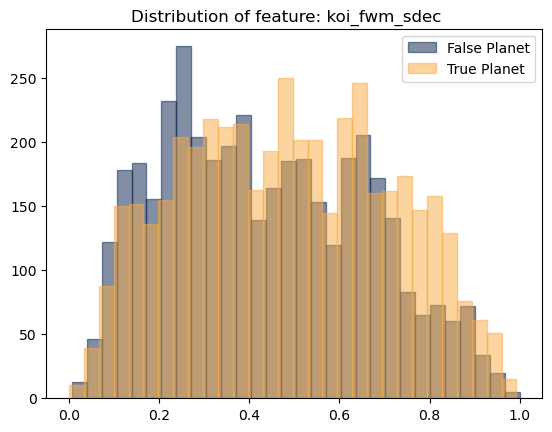

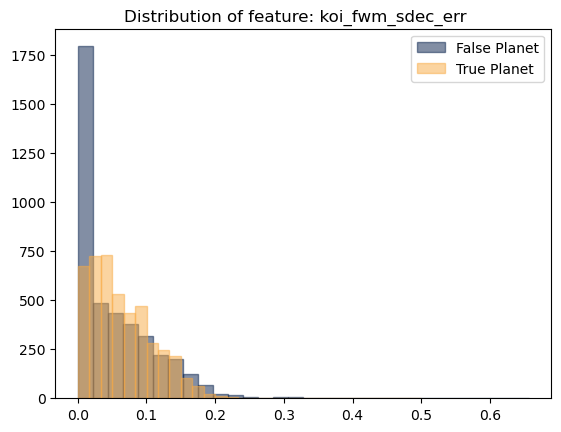

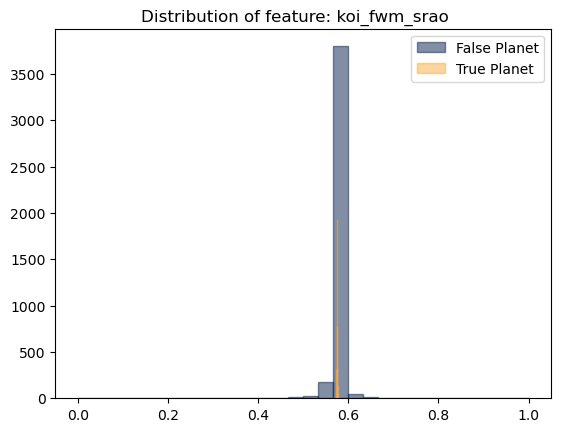

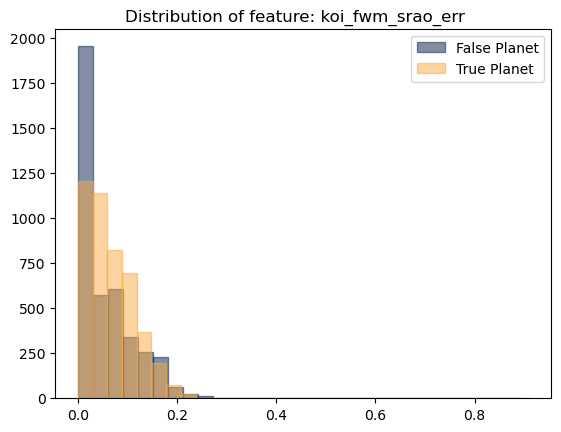

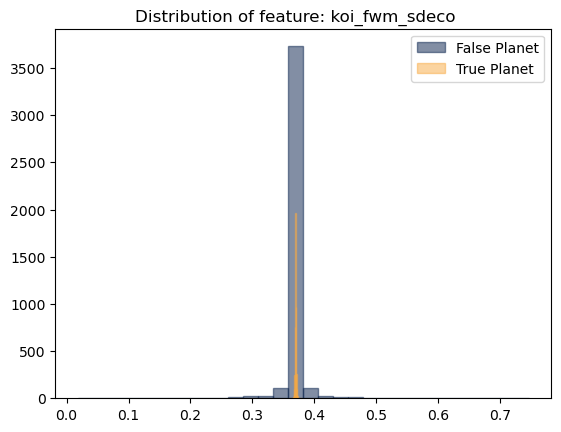

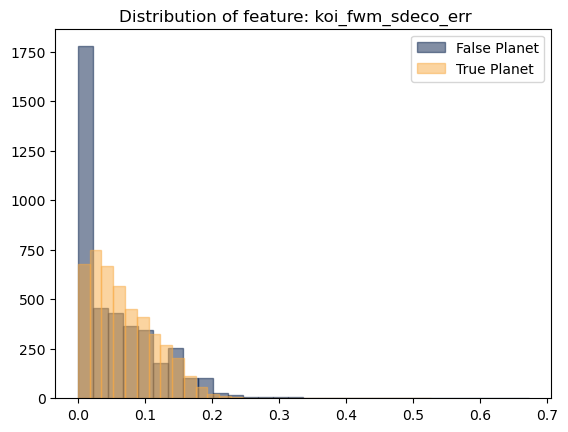

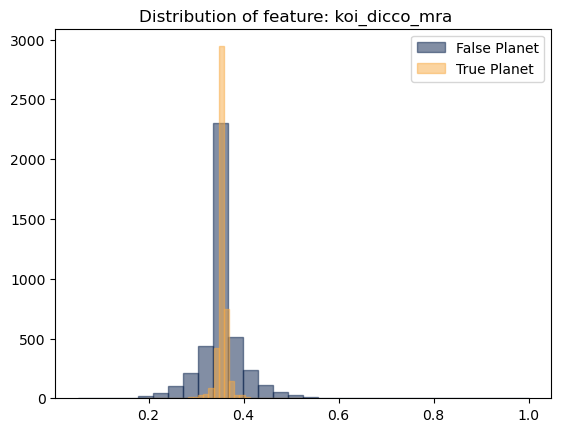

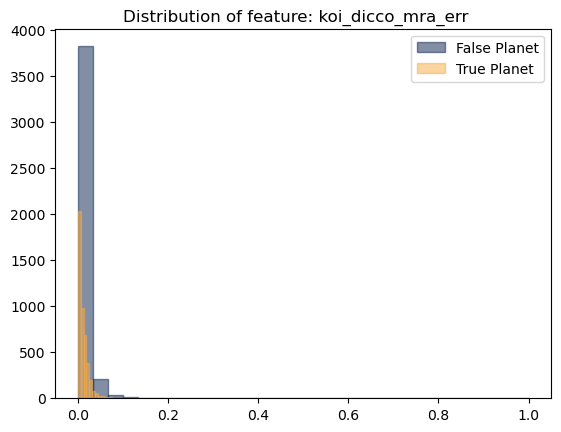

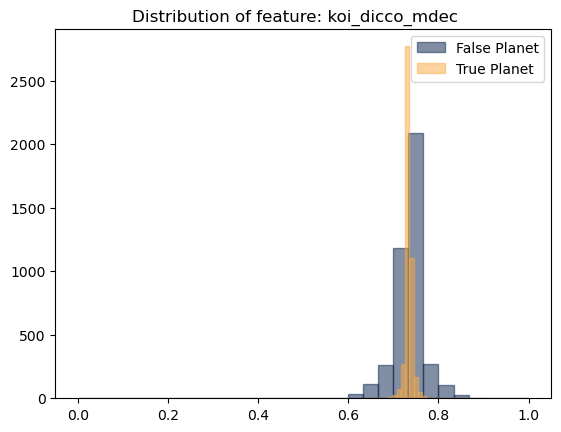

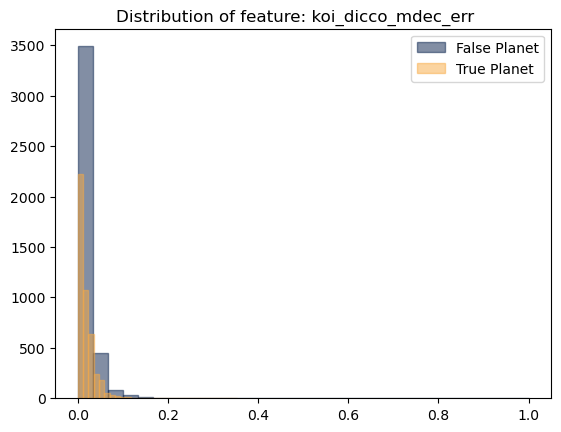

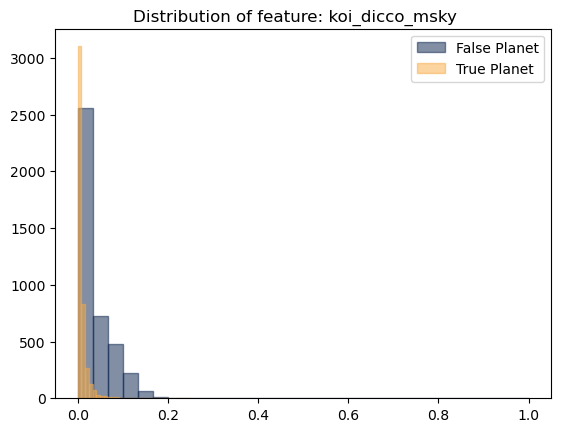

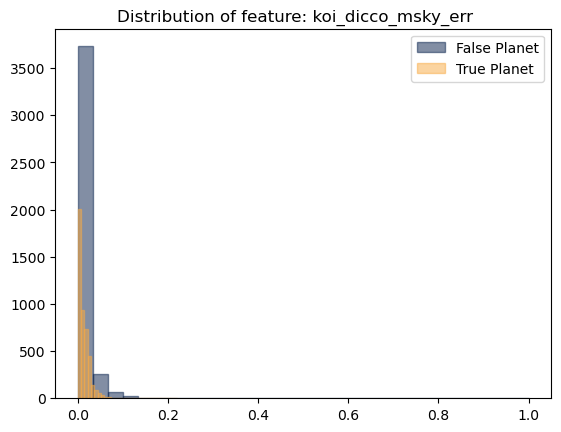

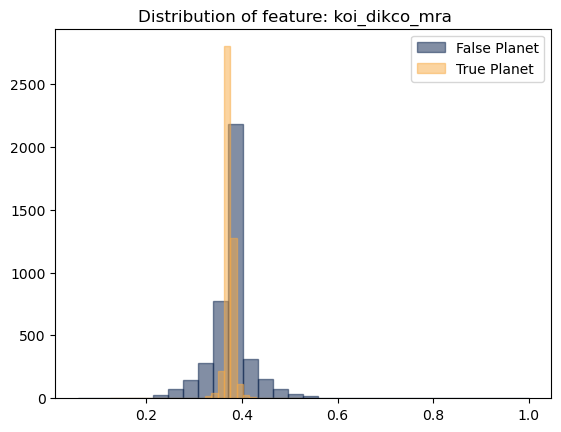

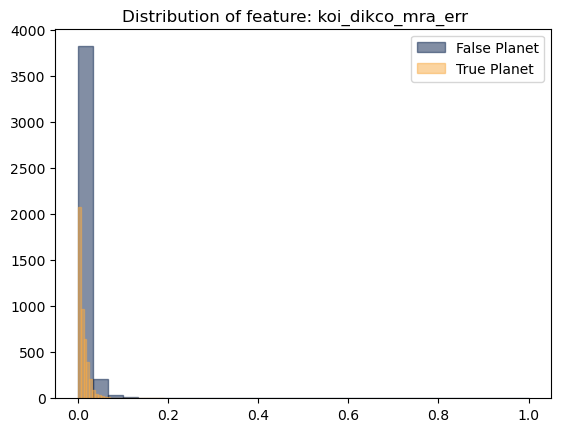

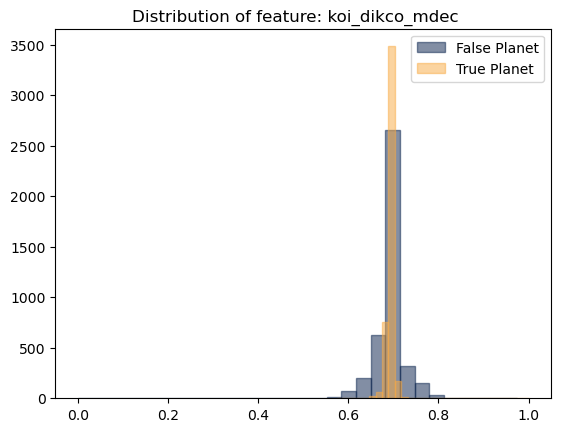

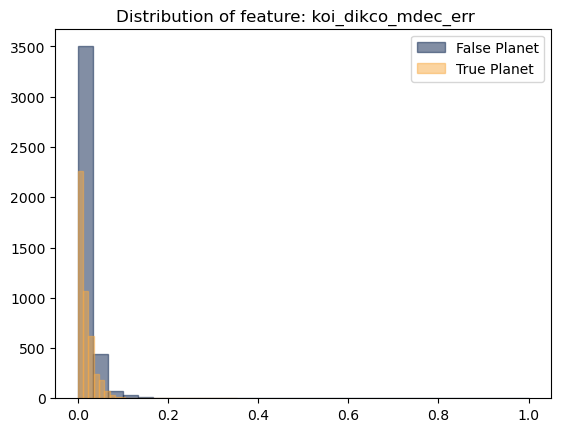

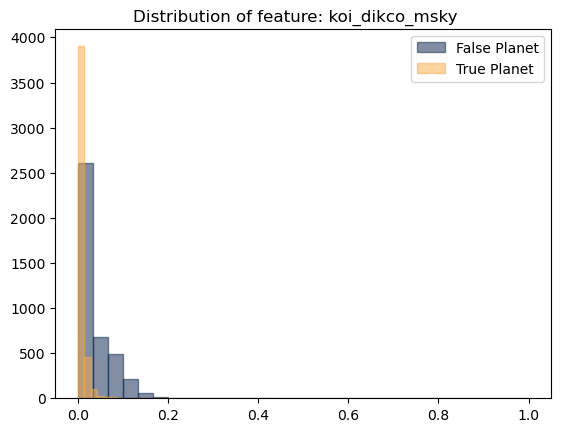

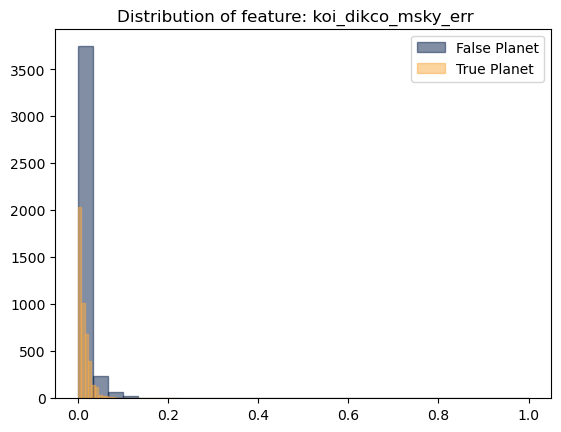

In [22]:
print('Plot After the scaling and KNNImputer')
plot_top_7_difference(X_train=X_train)
plot_hist_feature_distributions(X_train=X_train)
X_train_0, X_train_1 = compute_train_0_1(X_train=X_train, y_train=y_train)
plot_hist_feature_distributions(X_train=X_train_0)
plot_hist_feature_distributions(X_train=X_train_1)
plot_hist_feature_distributions_0_1(X_train_0=X_train_0, X_train_1=X_train_1)

# Feature Selection

Feature selection is a technique that associates a score with each feature and, based on a threshold T, thresholding is carried out so as to leave only the most important features. This technique is used to reduce overfitting and computational times.

It is done through the use of a Random Forest which provides us with the importance of the features.

In [ ]:
N_JOBS = -1

In [23]:
feature_importances_ = compute_feature_importance(X_train=X_train,
                                                  y_train=y_train, n_jobs=N_JOBS)
print_feature_importance(X_train=X_train, feature_importances_=feature_importances_)

1: koi_fpflag_nt-----------------> 0.08492758876402964
2: koi_fpflag_co-----------------> 0.07717253253869638
3: koi_fpflag_ss-----------------> 0.07649591808348101
4: koi_dikco_msky----------------> 0.04490763821590827
5: koi_fpflag_ec-----------------> 0.03977905923549806
6: koi_dicco_msky----------------> 0.03611923642967834
7: koi_prad----------------------> 0.034452662608831466
8: koi_dor-----------------------> 0.026710928841139917
9: koi_ror-----------------------> 0.026540994881907504
10:koi_prad_err1-----------------> 0.02443996306768739
11:koi_prad_err2-----------------> 0.02135715961994039
12:koi_smet_err2-----------------> 0.015388311266416778
13:koi_dikco_mdec_err------------> 0.01479311198225907
14:koi_depth---------------------> 0.014704009536074526
15:koi_fwm_srao_err--------------> 0.011474417536332259
16:koi_dikco_mra-----------------> 0.011413438401583818
17:koi_ror_err1------------------> 0.011257744430949377
18:koi_dikco_msky_err------------> 0.011223988798385664
1

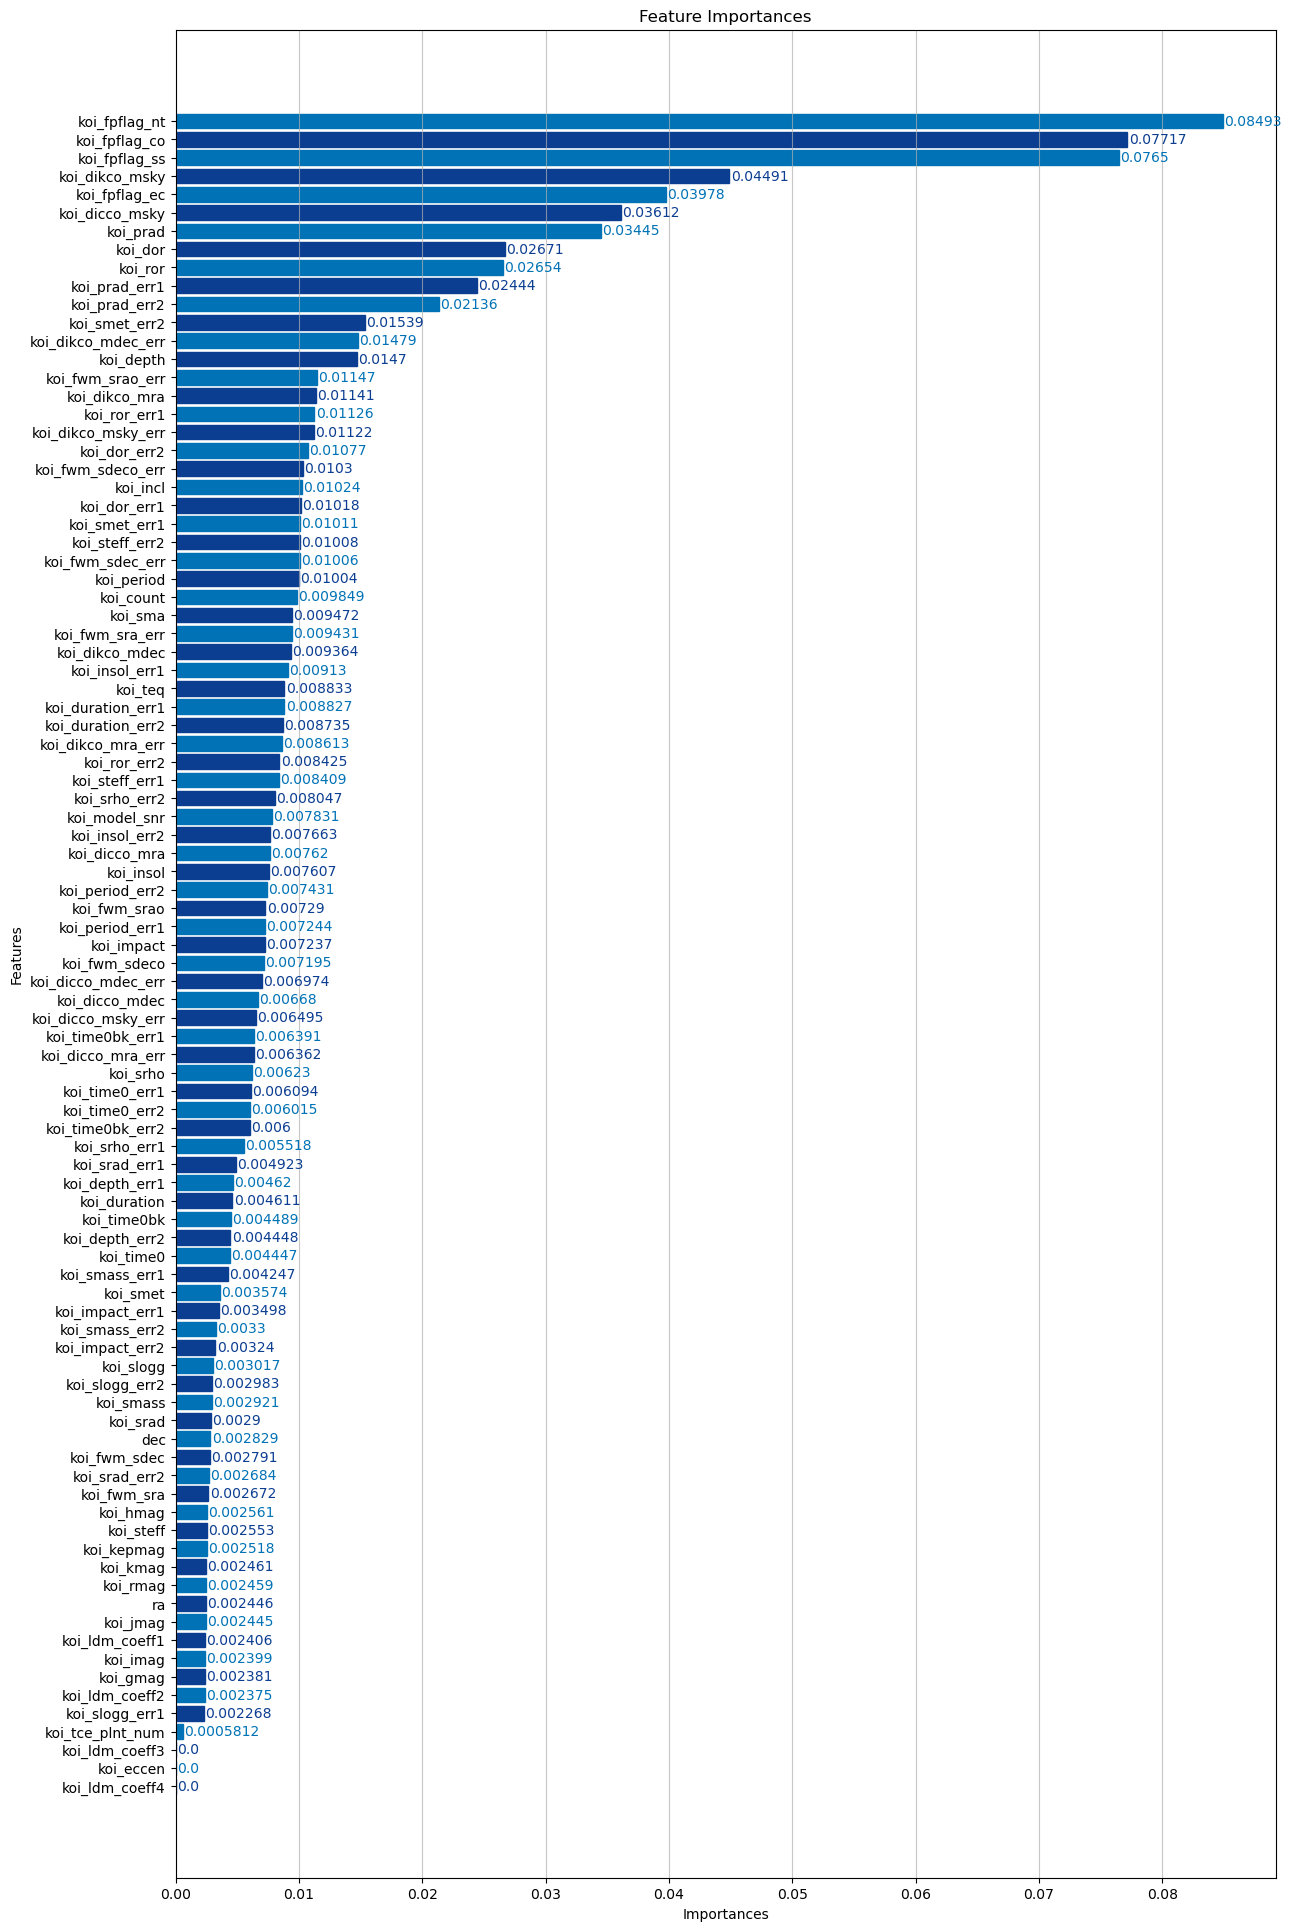

In [24]:
plot_feature_importances(X_train=X_train, feature_importances=feature_importances_)

In [25]:
PERCENTAGE = 0 # Drop features with importance = 0
X_train, columns_to_drop = feature_selection_rfc(X_train=X_train, feature_importances=feature_importances_,
                                                 percentage=PERCENTAGE)
print('Columns to drop:', columns_to_drop)
print('Shape of X_train data: ', X_train.shape)

Threshold computed:  0.0
Columns to drop: Index(['koi_eccen', 'koi_ldm_coeff4', 'koi_ldm_coeff3'], dtype='object')
Shape of X_train data:  (8608, 89)


# Dataset balancing

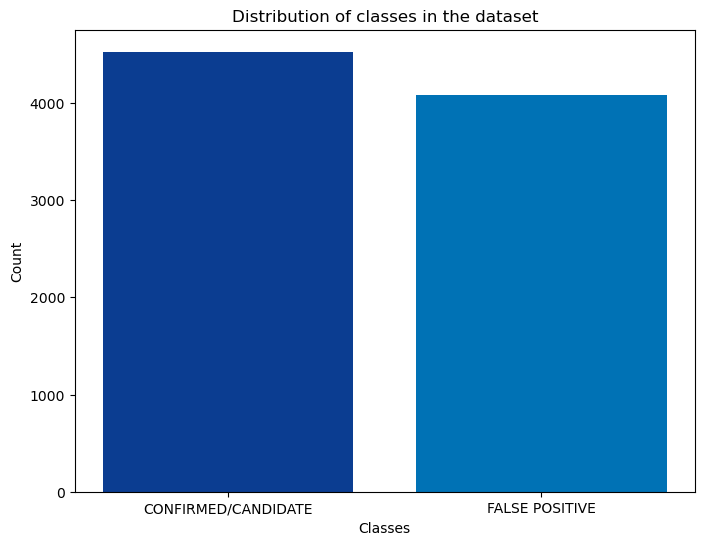

In [26]:
class_count_1, class_count_0 = plot_class_distribution(y_train=y_train)

In [27]:
print('Observations labeled 1:', class_count_1)
print('Observations labeled 0:', class_count_0)

Observations labeled 1: 4527
Observations labeled 0: 4081


In [28]:
# Save processed data
X_train.to_csv('../data/processed_data/X_kepler_followup.csv')
y_train.to_csv('../data/processed_data/y_kepler_followup.csv')

# Train Test Split

In [29]:
TESTSET_SIZE = 0.2
RANDOM_STATE = 42

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=TESTSET_SIZE, 
                                                    random_state=RANDOM_STATE, shuffle=True, stratify=None)

# Checking class distributions after the split

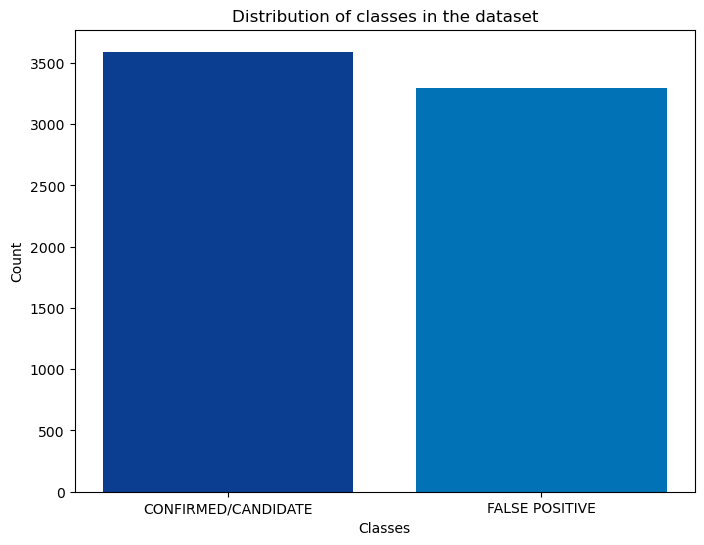

In [30]:
_, _ = plot_class_distribution(y_train=y_train)

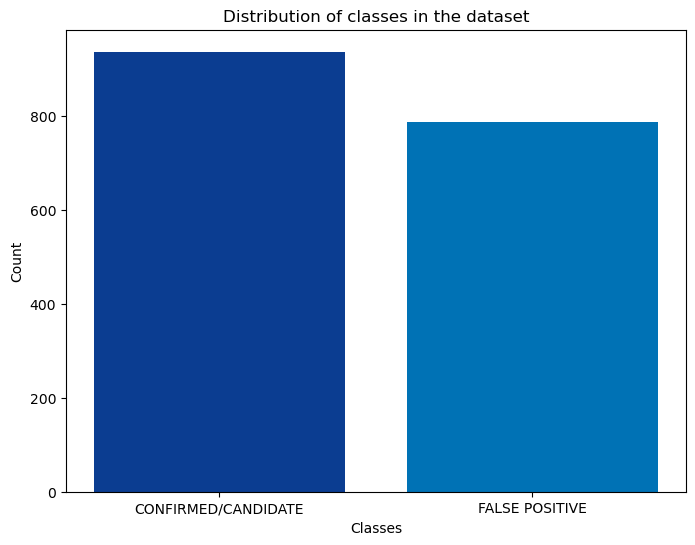

In [31]:
_, _ = plot_class_distribution(y_train=y_test)

In [32]:
print('Shape of X_train data: ', X_train.shape)
print('Shape of y_train data: ', y_train.shape)
print('Shape of X_test data: ', X_test.shape)
print('Shape of y_test data: ', y_test.shape)

Shape of X_train data:  (6886, 89)
Shape of y_train data:  (6886,)
Shape of X_test data:  (1722, 89)
Shape of y_test data:  (1722,)


# Grid Searh

A common method that determines optimal parameters by evaluating metrics
of the model

In [28]:
best_params, best_score, best_estimator = grid_search_param_optimization(X_train=X_train, 
                                                                         y_train=y_train, n_jobs=N_JOBS)
print('Best params:', best_params)
print('Best score:', best_score)
print('Best estimator:', best_estimator)

Fitting 5 folds for each of 360 candidates, totalling 1800 fits
[CV] END max_depth=2, max_features=2, min_samples_split=3, n_estimators=100; total time=   0.4s
[CV] END max_depth=2, max_features=2, min_samples_split=3, n_estimators=100; total time=   0.4s
[CV] END max_depth=2, max_features=2, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END max_depth=2, max_features=2, min_samples_split=3, n_estimators=100; total time=   0.4s
[CV] END max_depth=2, max_features=2, min_samples_split=2, n_estimators=100; total time=   0.5s
[CV] END max_depth=2, max_features=2, min_samples_split=3, n_estimators=100; total time=   0.5s
[CV] END max_depth=2, max_features=2, min_samples_split=2, n_estimators=100; total time=   0.5s
[CV] END max_depth=2, max_features=2, min_samples_split=2, n_estimators=100; total time=   0.6s
[CV] END max_depth=2, max_features=2, min_samples_split=3, n_estimators=100; total time=   0.6s
[CV] END max_depth=2, max_features=2, min_samples_split=2, n_estimators=

In [33]:
# Best params: {'max_depth': 11, 'max_features': None, 'min_samples_split': 5, 'n_estimators': 300}
# Best score: 0.996659931510098
# Best estimator: RandomForestClassifier(max_depth=11, max_features=None, min_samples_split=5,
#                        n_estimators=300)

# Best params: {'max_depth': None, 'max_features': 5, 'min_samples_split': 7, 'n_estimators': 300}
# Best score: 0.9822833761790477
# Best estimator: RandomForestClassifier(max_features=5, min_samples_split=7, n_estimators=300,
#                        n_jobs=-1)

# best_params = {}
# best_params['n_estimators'] = 300
# best_params['max_features'] = None
# best_params['max_depth'] = 11
# best_params['min_samples_split'] = 5

# Random Forest Classifier

A random forest classifier.

A random forest is a metaestimator that fits a set of decision tree classifiers on various subsamples of the dataset and uses averaging to improve predictive accuracy and control overfitting.

In [34]:
# Extracting best hyperparameters
N_ESTIMATORS = best_params['n_estimators'] # The number of trees in the forest
MAX_FEATURE = best_params['max_features'] # The number of features to consider when looking for the best split
MAX_DEPTH = best_params['max_depth'] # The maximum depth of the tree
MIN_SAMPLES_SPLIT = best_params['min_samples_split'] # Minimum number of samples required to split a node into terno
CRITERION = 'entropy' # The function to measure the quality of a split

from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=N_ESTIMATORS, criterion=CRITERION, 
                               max_depth=MAX_DEPTH, max_features=MAX_FEATURE,
                               min_samples_split=MIN_SAMPLES_SPLIT, random_state=RANDOM_STATE, n_jobs=N_JOBS)

model.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', max_depth=11, max_features=None,
                       min_samples_split=5, n_estimators=300, n_jobs=-1,
                       random_state=42)

$$
\text{Accuracy}: \frac{\text{true positives + true negatives}}{\text{true positives + true negatives + false positives + false negatives}}
$$ 


$$
\text{F-score}: 2 \cdot \frac{\text{Precision} \cdot \text{Recall}}{\text{Precision} + \text{Recall}}
$$

$$
\text{Precision}: \frac{\text{true positives}}{\text{true positives + false positives}}
$$


$$
\text{Recall}: \frac{\text{true positives}}{\text{true positives + false negatives}}
$$

Accuracy: 0.9976771196283392
F1-score: 0.9978632478632479
Precision: 0.9978632478632479
Recall: 0.9978632478632479


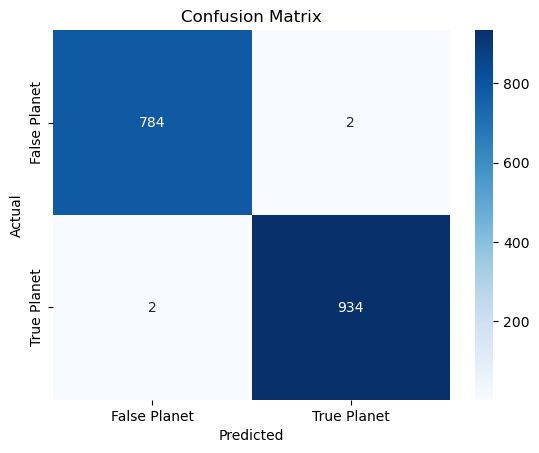

"\nN_ESTIMATORS = 300\nMAX_FEATURE = 5\nMAX_DEPTH = None\nMIN_SAMPLES_SPLIT = 7\nCRITERION = 'entropy'\nAccuracy: 97,96%\nF1-score: 98,11%\nPrecision: 98,91%\nRecall: 97,32%\ncm: [[776, 10][25, 911]]\n"

In [36]:
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score

predictions = model.predict(X_test)

# Determine performance metrics
cm = confusion_matrix(y_test, predictions)
print('Accuracy:', accuracy_score(y_test, predictions))
print('F1-score:', f1_score(y_test, predictions))
print('Precision:', precision_score(y_test, predictions))
print('Recall:', recall_score(y_test, predictions))
plot_confusion_matrix(cm)

"""
N_ESTIMATORS = 300
MAX_FEATURE = None
MAX_DEPTH = 11
MIN_SAMPLES_SPLIT = 5
CRITERION = 'entropy'
Accuracy: 99,76%
F1-score: 99,78%
Precision: 99,78%
Recall: 9978%
cm: [[784, 2][2, 934]]
"""

In [37]:
print_feature_importance(X_train=X_train, feature_importances_=model.feature_importances_)

1: koi_fpflag_ss-----------------> 0.30524667858484017
2: koi_fpflag_nt-----------------> 0.30157147379674454
3: koi_fpflag_co-----------------> 0.283459632532535
4: koi_fpflag_ec-----------------> 0.08203778804038955
5: koi_slogg_err1----------------> 0.0019554412170391744
6: koi_sma-----------------------> 0.001938606980819994
7: koi_prad----------------------> 0.0010747253450223572
8: koi_smet----------------------> 0.0010498219524535197
9: koi_time0---------------------> 0.0009908396784411462
10:koi_slogg_err2----------------> 0.0009233049708087215
11:koi_period--------------------> 0.000866416559477503
12:koi_ror-----------------------> 0.0008242941916177373
13:koi_time0bk-------------------> 0.0008132596401560701
14:koi_depth---------------------> 0.0007998694354817601
15:koi_ror_err1------------------> 0.0006494867133196105
16:koi_ror_err2------------------> 0.0006319132665392947
17:koi_duration_err1-------------> 0.0006050683144588228
18:koi_srho_err1-----------------> 0.000577

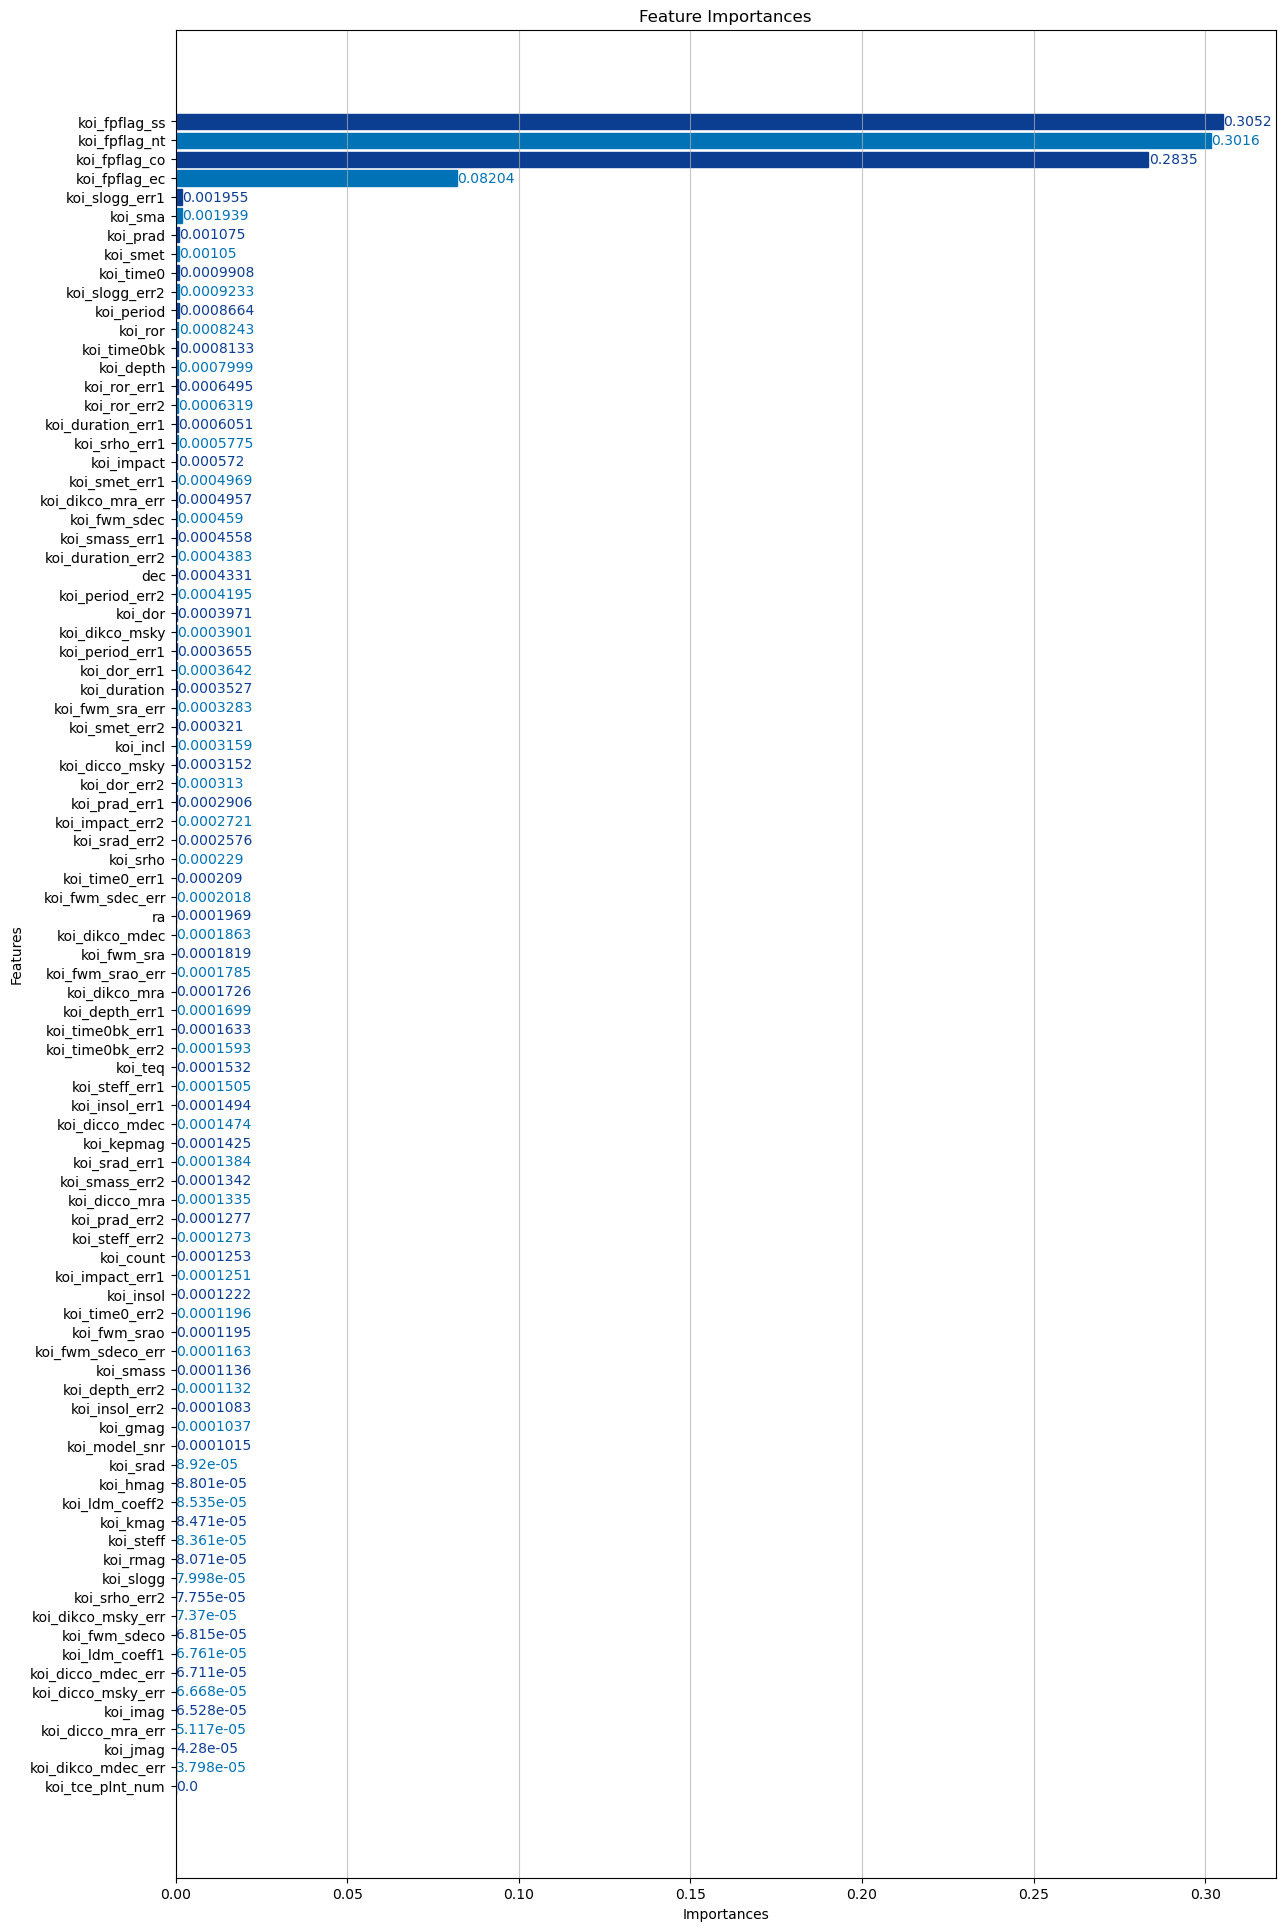

In [38]:
plot_feature_importances(X_train=X_train, feature_importances=model.feature_importances_)

In [40]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

# Decision Tree
dt_params = {'max_depth': [None, 10, 20, 30], 'min_samples_split': [2, 5, 10, 11]}
dt_classifier = DecisionTreeClassifier()
dt_grid_search = GridSearchCV(dt_classifier, dt_params, cv=5, n_jobs=N_JOBS, verbose=2)
dt_grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] END ................max_depth=None, min_samples_split=2; total time=   0.3s
[CV] END ................max_depth=None, min_samples_split=2; total time=   0.3s
[CV] END ................max_depth=None, min_samples_split=2; total time=   0.4s
[CV] END ................max_depth=None, min_samples_split=2; total time=   0.4s
[CV] END ................max_depth=None, min_samples_split=5; total time=   0.4s
[CV] END ................max_depth=None, min_samples_split=5; total time=   0.4s
[CV] END ................max_depth=None, min_samples_split=5; total time=   0.4s
[CV] END ................max_depth=None, min_samples_split=2; total time=   0.4s
[CV] END ................max_depth=None, min_samples_split=5; total time=   0.3s
[CV] END ................max_depth=None, min_samples_split=5; total time=   0.3s
[CV] END ...............max_depth=None, min_samples_split=10; total time=   0.3s
[CV] END ...............max_depth=None, min_samp

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'max_depth': [None, 10, 20, 30],
                         'min_samples_split': [2, 5, 10, 11]},
             verbose=2)

Best parameters for Decision Tree: {'max_depth': 30, 'min_samples_split': 2}
Accuracy: 0.9976771196283392
F1-score: 0.9978655282817502
Precision: 0.9968017057569296
Recall: 0.9989316239316239


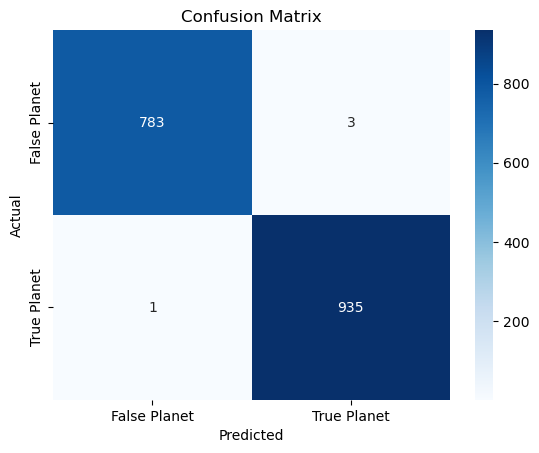

In [41]:
print("Best parameters:", dt_grid_search.best_params_)
dt_predictions = dt_grid_search.predict(X_test)
cm = confusion_matrix(y_test, dt_predictions)
print('Accuracy:', accuracy_score(y_test, dt_predictions))
print('F1-score:', f1_score(y_test, dt_predictions))
print('Precision:', precision_score(y_test, dt_predictions))
print('Recall:', recall_score(y_test, dt_predictions))
plot_confusion_matrix(cm)

# Best parameters for Decision Tree: {'max_depth': 30, 'min_samples_split': 2}
# Accuracy: 99,76%
# F1-score: 99,78%
# Precision: 99,68%
# Recall: 99,89%

In [42]:
from sklearn.neighbors import KNeighborsClassifier

# K-Nearest Neighbors
knn_params = {'n_neighbors': [3, 5, 7, 11, 15, 33]}
knn_classifier = KNeighborsClassifier(n_jobs=N_JOBS)
knn_grid_search = GridSearchCV(knn_classifier, knn_params, cv=5, n_jobs=N_JOBS, verbose=2)
knn_grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] END ......................................n_neighbors=3; total time=   0.3s
[CV] END ......................................n_neighbors=5; total time=   0.3s
[CV] END ......................................n_neighbors=5; total time=   0.3s
[CV] END ......................................n_neighbors=3; total time=   0.3s
[CV] END ......................................n_neighbors=3; total time=   0.4s
[CV] END ......................................n_neighbors=3; total time=   0.4s
[CV] END ......................................n_neighbors=3; total time=   0.4s
[CV] END ......................................n_neighbors=5; total time=   0.2s
[CV] END ......................................n_neighbors=5; total time=   0.3s
[CV] END ......................................n_neighbors=5; total time=   0.6s
[CV] END ......................................n_neighbors=7; total time=   0.2s
[CV] END ......................................n_

GridSearchCV(cv=5, estimator=KNeighborsClassifier(n_jobs=-1), n_jobs=-1,
             param_grid={'n_neighbors': [3, 5, 7, 11, 15, 33]}, verbose=2)

Best parameters: {'n_neighbors': 5}
Accuracy: 0.9128919860627178
F1-score: 0.922360248447205
Precision: 0.8945783132530121
Recall: 0.9519230769230769


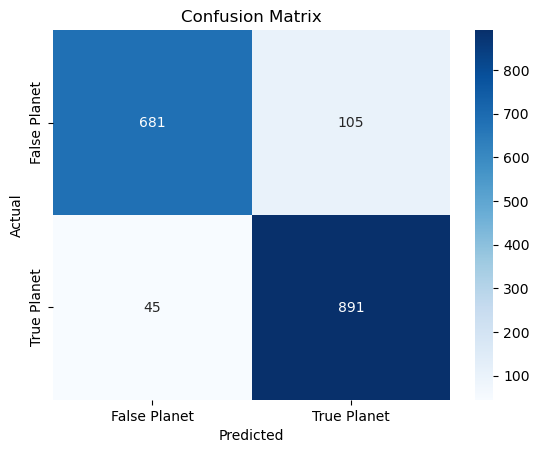

In [43]:
print("Best parameters:", knn_grid_search.best_params_)
knn_predictions = knn_grid_search.predict(X_test)
cm = confusion_matrix(y_test, knn_predictions)
print('Accuracy:', accuracy_score(y_test, knn_predictions))
print('F1-score:', f1_score(y_test, knn_predictions))
print('Precision:', precision_score(y_test, knn_predictions))
print('Recall:', recall_score(y_test, knn_predictions))
plot_confusion_matrix(cm)

# Best parameters: {'n_neighbors': 5}
# Accuracy: 91,28%
# F1-score: 92,23%
# Precision: 89,45%
# Recall: 95,19%

In [44]:
from sklearn.ensemble import GradientBoostingClassifier

# Gradient Boosting
gb_params = {'n_estimators': [50, 100, 200, 500], 'learning_rate': [0.01, 0.1, 0.2, 0.001, 0.4]}
gb_classifier = GradientBoostingClassifier()
gb_grid_search = GridSearchCV(gb_classifier, gb_params, cv=5, n_jobs=N_JOBS, verbose=2)
gb_grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] END ................learning_rate=0.01, n_estimators=50; total time=   7.7s
[CV] END ................learning_rate=0.01, n_estimators=50; total time=   7.9s
[CV] END ................learning_rate=0.01, n_estimators=50; total time=   8.1s
[CV] END ................learning_rate=0.01, n_estimators=50; total time=   8.5s
[CV] END ................learning_rate=0.01, n_estimators=50; total time=   9.8s
[CV] END ...............learning_rate=0.01, n_estimators=100; total time=  21.6s
[CV] END ...............learning_rate=0.01, n_estimators=100; total time=  23.6s
[CV] END ...............learning_rate=0.01, n_estimators=100; total time=  24.7s
[CV] END ...............learning_rate=0.01, n_estimators=100; total time=  30.7s
[CV] END ...............learning_rate=0.01, n_estimators=100; total time=  31.5s
[CV] END ...............learning_rate=0.01, n_estimators=200; total time=  52.2s
[CV] END ...............learning_rate=0.01, n_e

GridSearchCV(cv=5, estimator=GradientBoostingClassifier(), n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1, 0.2, 0.001, 0.4],
                         'n_estimators': [50, 100, 200, 500]},
             verbose=2)

Best parameters: {'learning_rate': 0.01, 'n_estimators': 500}
Accuracy: 0.9128919860627178
F1-score: 0.922360248447205
Precision: 0.8945783132530121
Recall: 0.9519230769230769


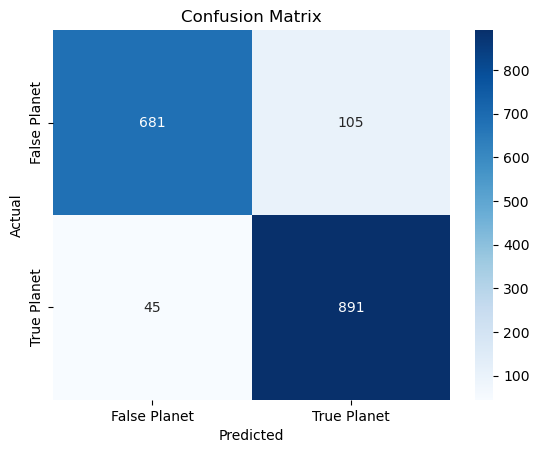

In [45]:
print("Best parameters:", gb_grid_search.best_params_)
gb_predictions = knn_grid_search.predict(X_test)
cm = confusion_matrix(y_test, gb_predictions)
print('Accuracy:', accuracy_score(y_test, gb_predictions))
print('F1-score:', f1_score(y_test, gb_predictions))
print('Precision:', precision_score(y_test, gb_predictions))
print('Recall:', recall_score(y_test, gb_predictions))
plot_confusion_matrix(cm)

# Best parameters: {'learning_rate': 0.01, 'n_estimators': 500}
# Accuracy: 91,28%
# F1-score: 92,23%
# Precision: 89,45%
# Recall: 95,19%